In [1]:
from anndata import AnnData
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import seaborn as sns
from numpy.random import default_rng
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.stats import zscore

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.10 pynndescent==0.5.7
squidpy==1.2.2


# Settings

In [2]:
sc.settings.set_figure_params(dpi=160, fontsize=20, dpi_save=300, figsize=(7,7))

# Read in data

In [3]:
# Path to HCC files
ROI14_meta = '~/Documents/Masterarbeit/data/Run35a_ROI14_DATA/Run35a_ROI14_METADATA.csv'
ROI14_expr = '~/Documents/Masterarbeit/data/Run35a_ROI14_DATA/Run35a_ROI14_EXPRESSION.csv'
ROI15_meta = '~/Documents/Masterarbeit/data/Run35a_ROI15_DATA/Run35a_ROI15_METADATA.csv'
ROI15_expr = '~/Documents/Masterarbeit/data/Run35a_ROI15_DATA/Run35a_ROI15_EXPRESSION.csv'
ROI16_meta = '~/Documents/Masterarbeit/data/Run35a_ROI16_DATA/Run35a_ROI16_METADATA.csv'
ROI16_expr = '~/Documents/Masterarbeit/data/Run35a_ROI16_DATA/Run35a_ROI16_EXPRESSION.csv'

In [4]:
# include only immune marker
include =[ 
'CD45',  
'CD45RO',   
'CD3',
# CD2,
'CD4',
'CD8',    
'CD25-1',     
'FoxP3',
'CD152 CTLA4',   
#PD-L1
'CD19',     
'CD20 Cytoplasmic',
'CD38',     
'CD138', 
'CD69',    
'CD56',    
'CD314 NKG2D',     
'CD61',
'CD68', 
'CD206',     
'CD163',# IN ROI19 on tumor       
'CD11c', 
'CD123',
'CD15',    
'CD33',  
'CD117',   
'HLA-DR',
'Ki-67',     
'HNF-4-alpha',  
'Cytokeratin',    
'CD99',
'CD31',    
'CD105',    
'Podoplanin',
'SM Actin',
'Myosin SM',
'CollagenIII',
'CollagenIV',
'Fibronectin',
'Galectin9',    
]


# Read in data
### Data: merged Data (with reduced number of marker, removed artefacts)

In [5]:
def read_csv(file_path_exp, filepath_meta, sample):
    # Reading Data (expression & metadata)
    raw_data = pd.read_csv(file_path_exp, index_col="ID", sep='\t') + 1
    meta_data = pd.read_csv(filepath_meta, index_col="ID", sep='\t') + 1
    
    # Arcsinh transformation
    expression_data = raw_data.apply(lambda x: np.arcsinh(x), axis=0) #apply function to each column, but it dosen't matter -> same results if using per row
    
    # include only these marker
    raw_data = raw_data[include]
    expression_data = expression_data[include]
    
    # scaling: compute z score
    zscore_df = zscore(expression_data[expression_data.columns], axis=0) # compute z-score for every column (double checked it)
    
    
    # Add column sample for batches, save sample dataframe, remove samples (in order to use df for annData format)
    expression_data.insert(0, 'Sample', sample)
    df_sample = expression_data['Sample'].to_frame()
    expression_data = expression_data.drop('Sample', axis=1)
    
    zscore_df.insert(0, 'Sample', sample)
    zscore_sample = zscore_df['Sample'].to_frame()
    zscore_df = zscore_df.drop('Sample', axis=1)    
    
    
    # generate AnnData
    coordinates = meta_data.loc[:, 'Cell Center X':'Cell Center Y'].to_numpy()
    adata = AnnData(expression_data,  obsm={"spatial": coordinates})
    adata_zscore = AnnData(zscore_df,  obsm={"spatial": coordinates})
    
    
      
    # add batches to AnnData.obs
    df_sample= df_sample.reset_index().drop('ID', axis=1).to_numpy()
    adata.obs['Sample'] = sample
    
    zscore_sample = zscore_sample.reset_index().drop('ID', axis=1).to_numpy()
    adata_zscore.obs['Sample'] = sample
    
    
    # add scaled layer to AnnData
    adata.layers['scaled'] = zscore_df
    
    return adata_zscore, expression_data, meta_data, df_sample, adata, raw_data

In [6]:
# Pancreas
P_ROI14_zscore, P_ROI14_exp, P_ROI14_m, P_sample_ROI14, P_adata_ROI14, P_raw_ROI14 = read_csv(ROI14_expr, ROI14_meta, 'ROI14')
P_ROI15_zscore, P_ROI15_exp, P_ROI15_m, P_sample_ROI15, P_adata_ROI15, P_raw_ROI15 = read_csv(ROI15_expr, ROI15_meta, 'ROI15')
P_ROI16_zscore, P_ROI16_exp, P_ROI16_m, P_sample_ROI16, P_adata_ROI16, P_raw_ROI16 = read_csv(ROI16_expr, ROI16_meta, 'ROI16')

/home/anja/.pyenv/versions/3.7.12/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/anja/.pyenv/versions/3.7.12/envs/thesis/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/anja/.pyenv/versions/3.7.12/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [7]:
# merge all raw data
raw_merge = pd.concat([P_raw_ROI14, P_raw_ROI15, P_raw_ROI16])

# merge all transfomed
adata_merged = ad.concat([P_adata_ROI14, P_adata_ROI15, P_adata_ROI16])

# merge z-score data
adata_zscore = ad.concat([P_ROI14_zscore, P_ROI15_zscore, P_ROI16_zscore])

/home/anja/.pyenv/versions/3.7.12/envs/thesis/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


# Marker distribution

## PCA

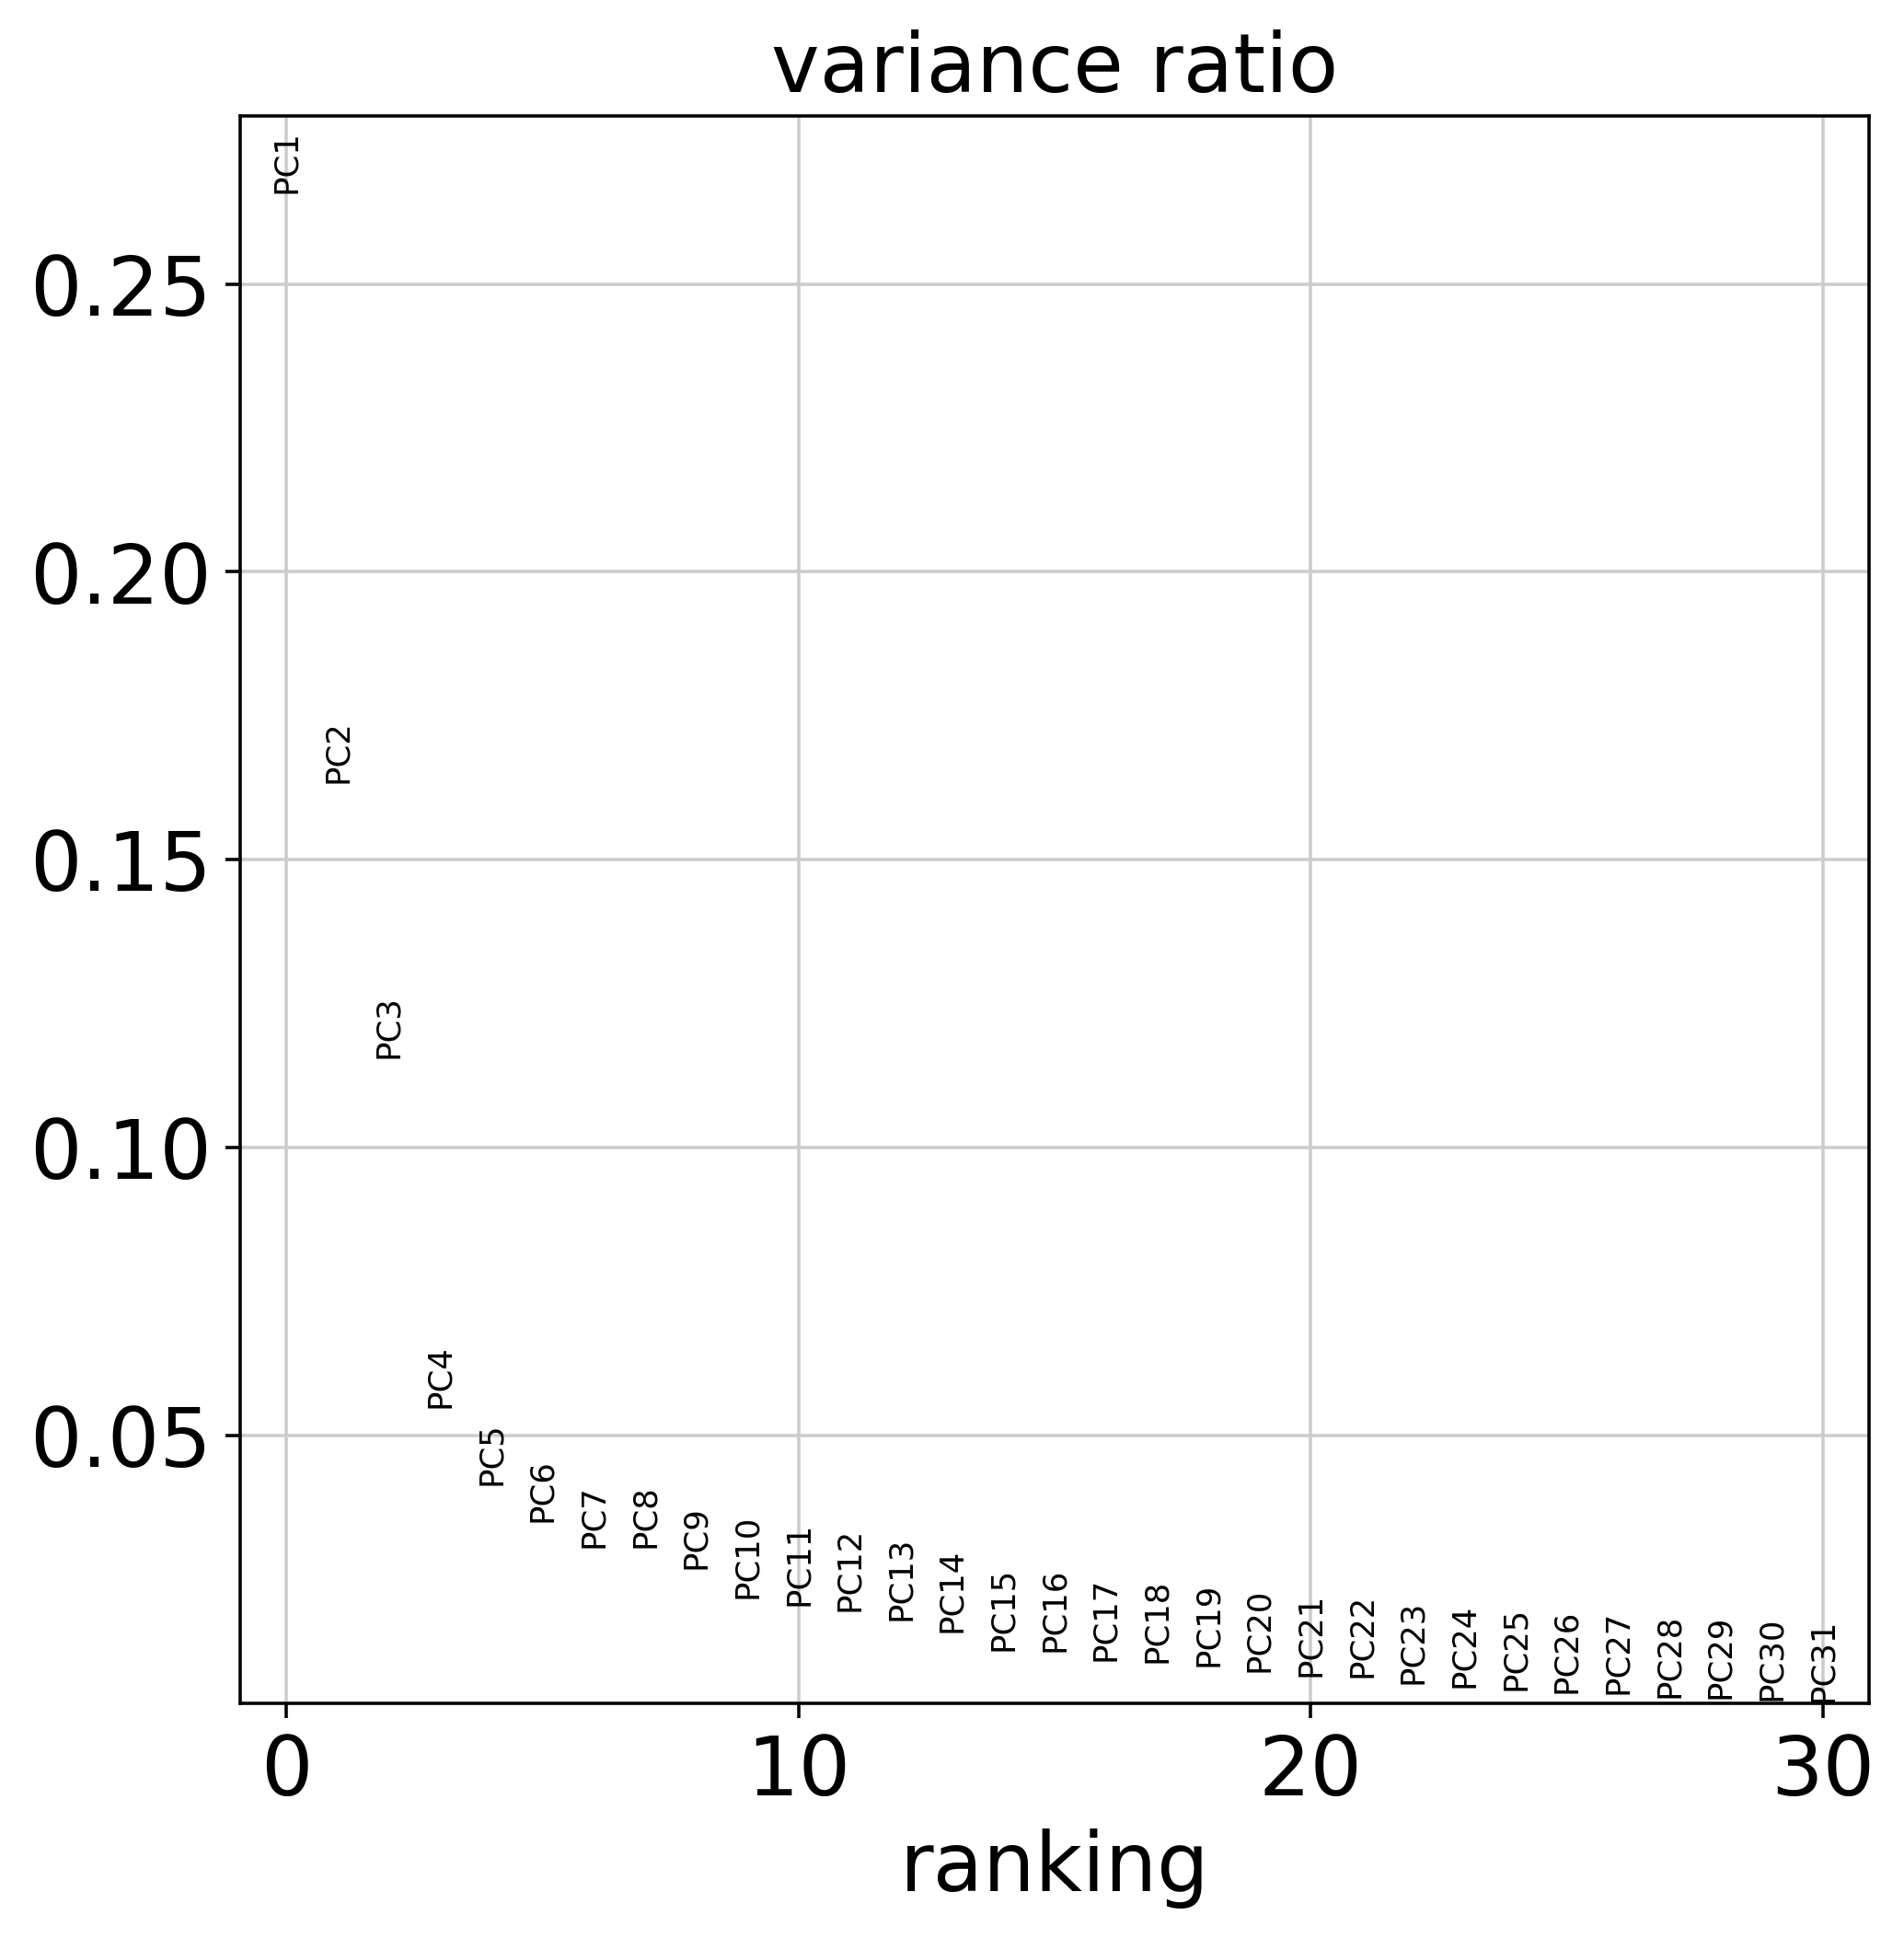

In [8]:
#sc.settings.set_figure_params(dpi=100, fontsize=14,figsize=(9,9))
sc.tl.pca(adata_zscore, svd_solver='arpack')
#sc.pl.pca(adadata_zscore)
sc.pl.pca_variance_ratio(adata_zscore, log=False)

# UMAP

In [9]:
# Computing the neighborhood graph
sc.pp.neighbors(adata_zscore, n_neighbors=15, n_pcs=4)
sc.tl.umap(adata_zscore, random_state=0, min_dist=0, spread=1) 
sc.tl.leiden(adata_zscore,resolution=0.6, key_added = "leiden")

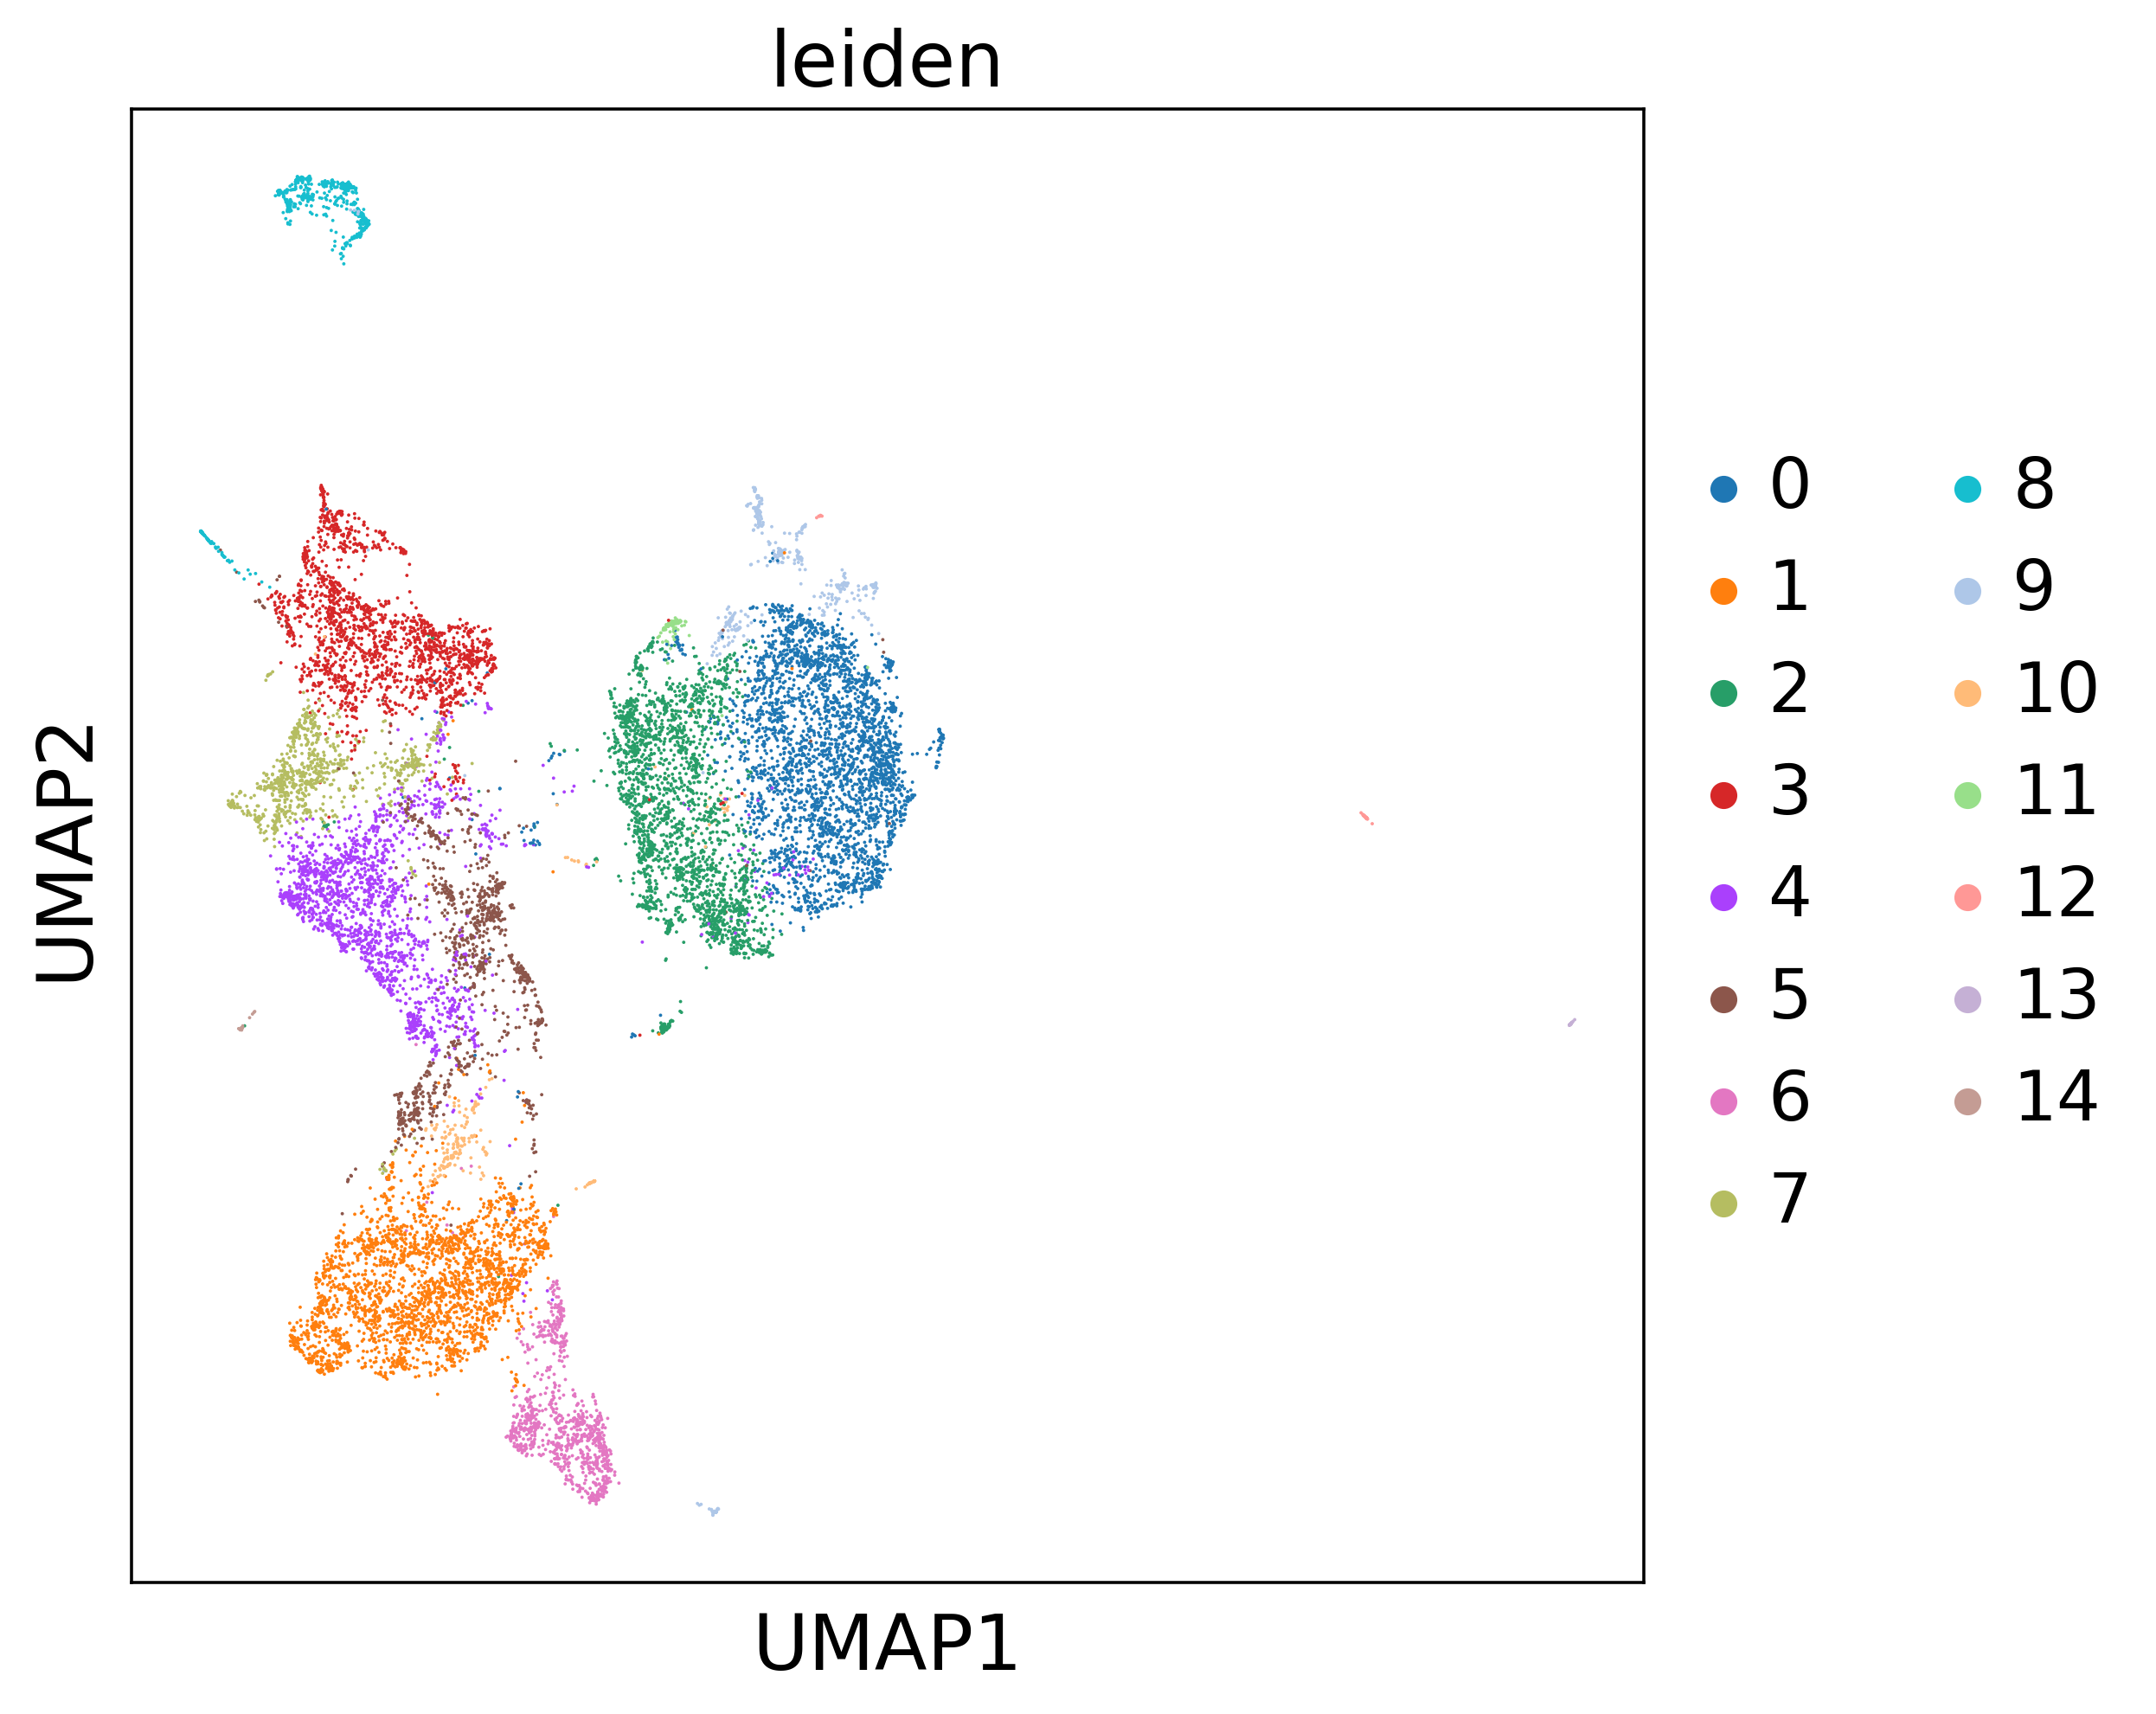

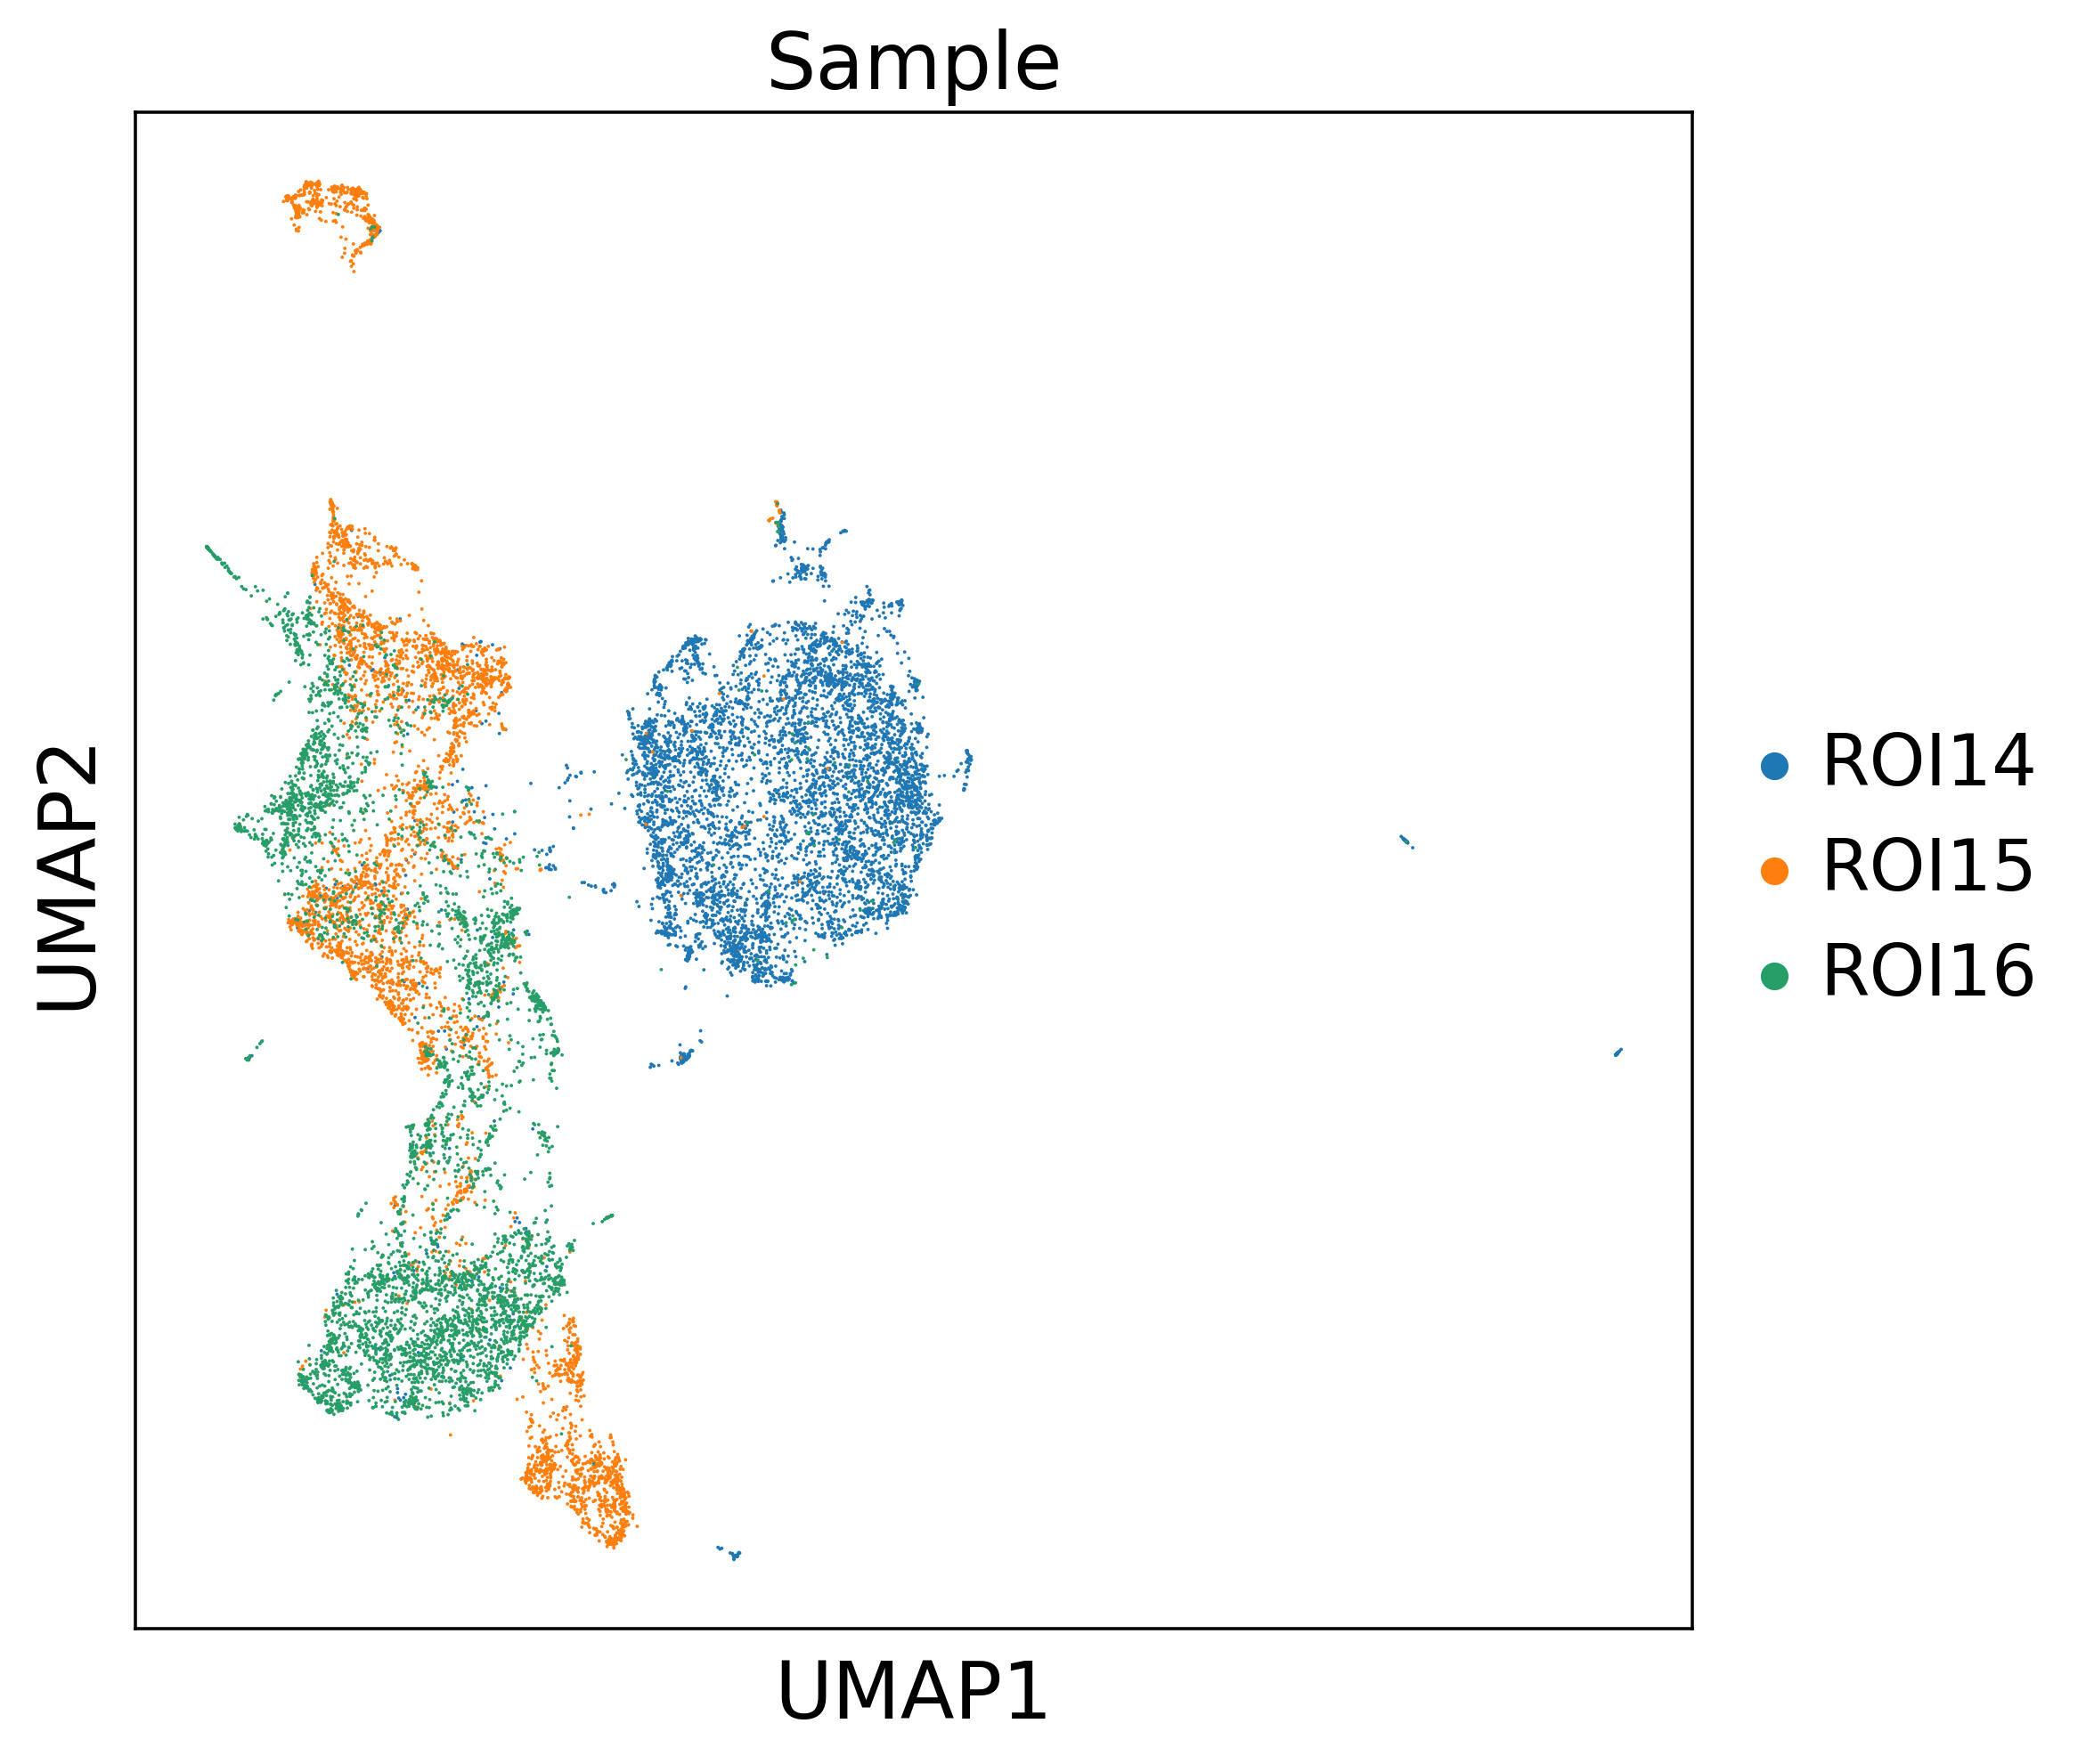

In [10]:
sc.pl.umap(adata_zscore, color ='leiden', s=3, use_raw=False, save='_leiden.pdf', legend_fontsize=18)
sc.pl.umap(adata_zscore, color ='Sample', s=3, use_raw=False, save='_batches.pdf', legend_fontsize=18)
# no difference to unscaled results

# Batch correction

In [11]:
from harmony import harmonize

In [12]:
corrected_data = harmonize(adata_zscore.obsm['X_pca'], adata_zscore.obs, batch_key = 'Sample')
adata_zscore.obsm['X_harmony'] = corrected_data

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).
Reach convergence after 10 iteration(s).


# UMAP: transfromed data

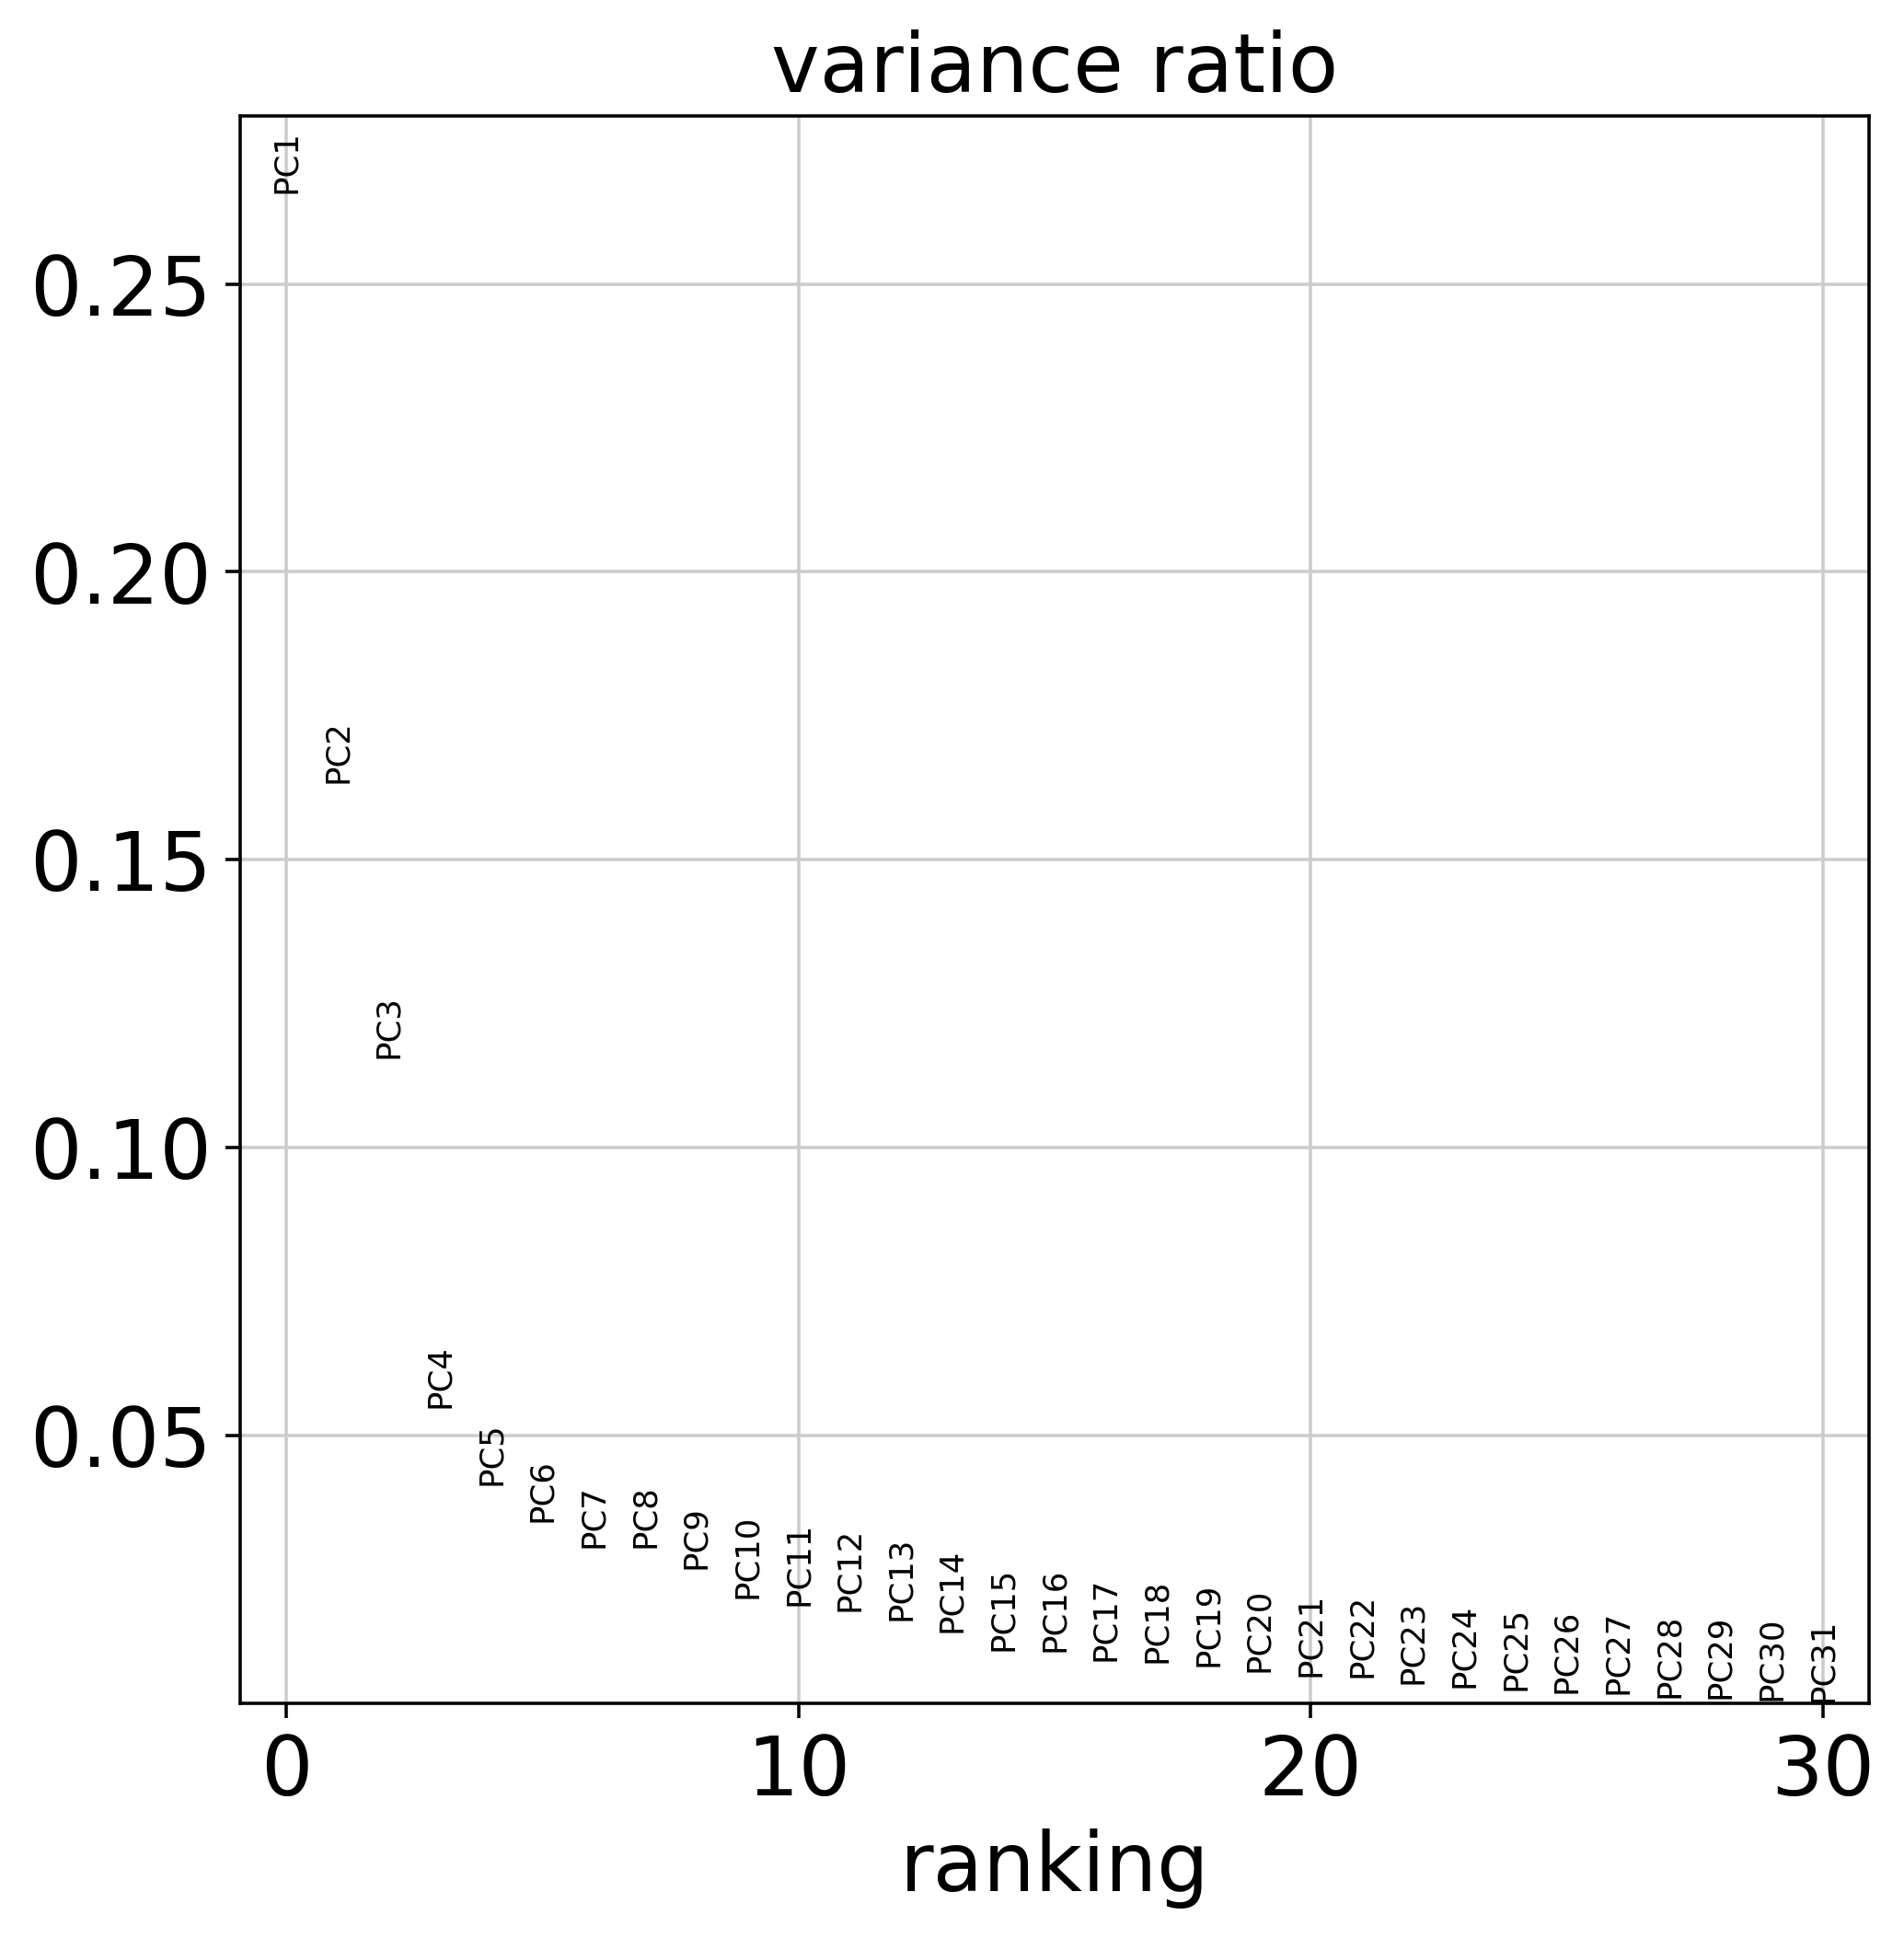

In [13]:
sc.pp.pca(adata_zscore)
sc.pl.pca_variance_ratio(adata_zscore, log=False)

In [14]:
sc.pp.neighbors(adata_zscore, n_neighbors=7, n_pcs=4, use_rep='X_harmony')
sc.tl.umap(adata_zscore,  random_state=0, min_dist=0.1, spread=0.5) 
sc.tl.leiden(adata_zscore,resolution=2, key_added = "leiden")

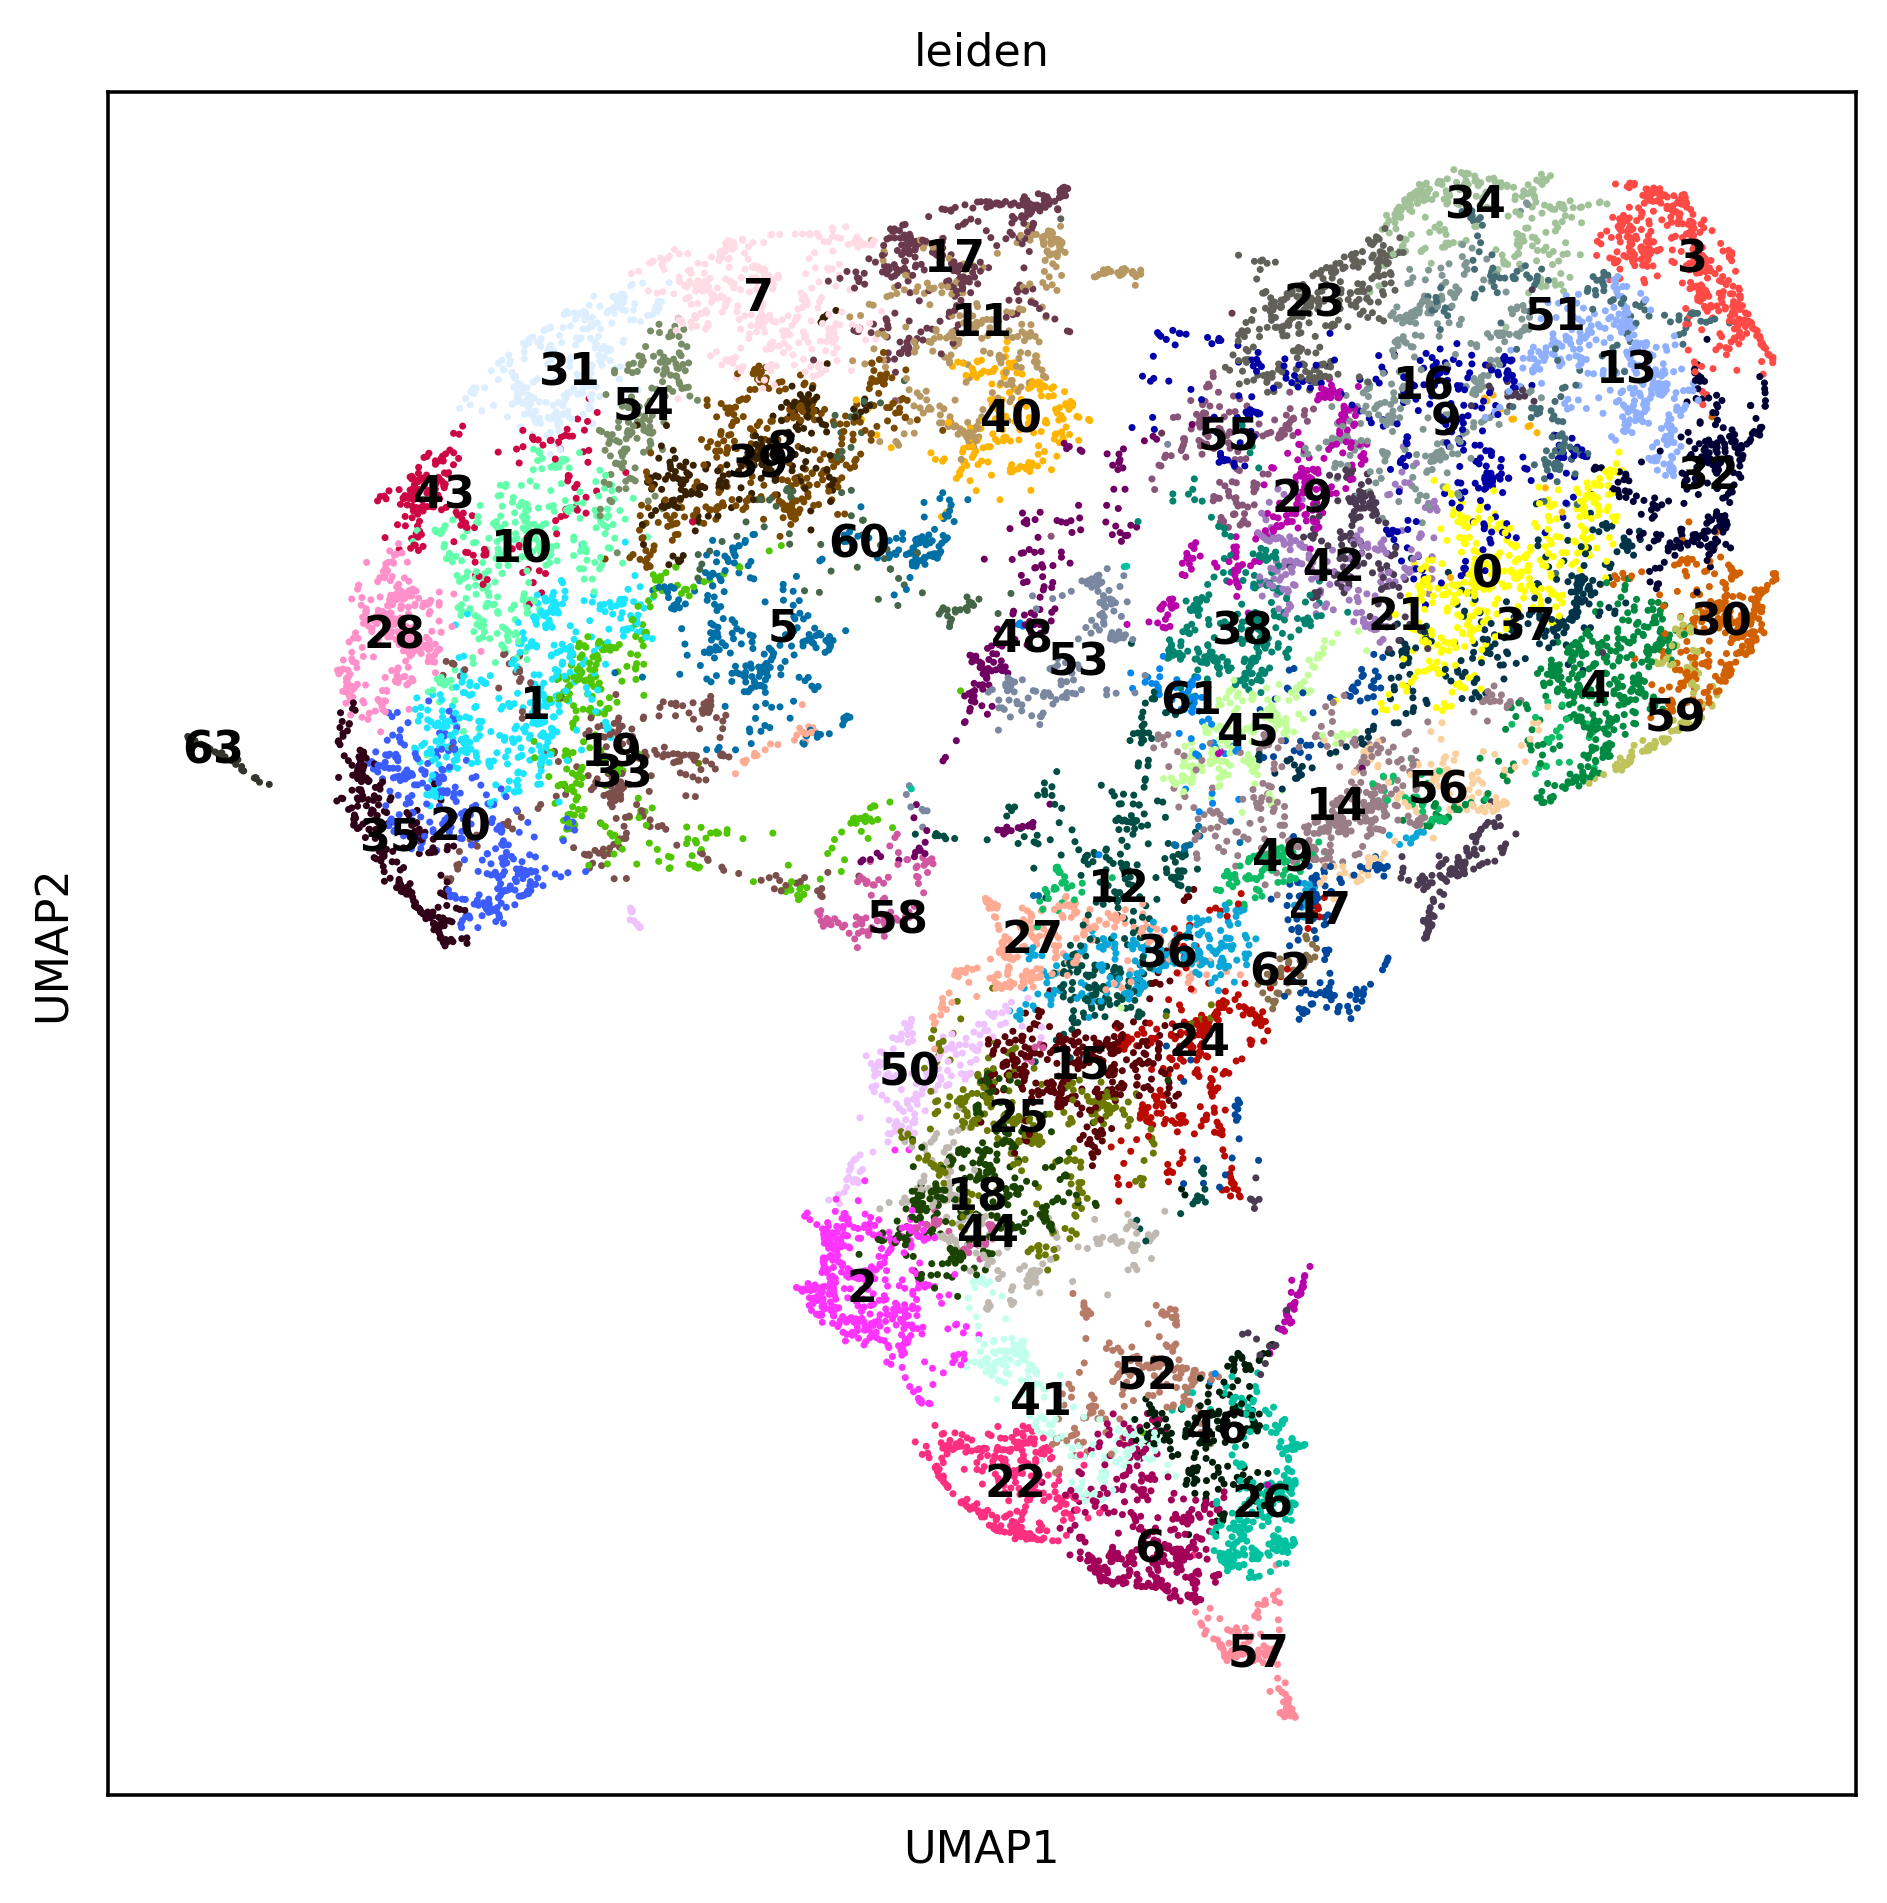

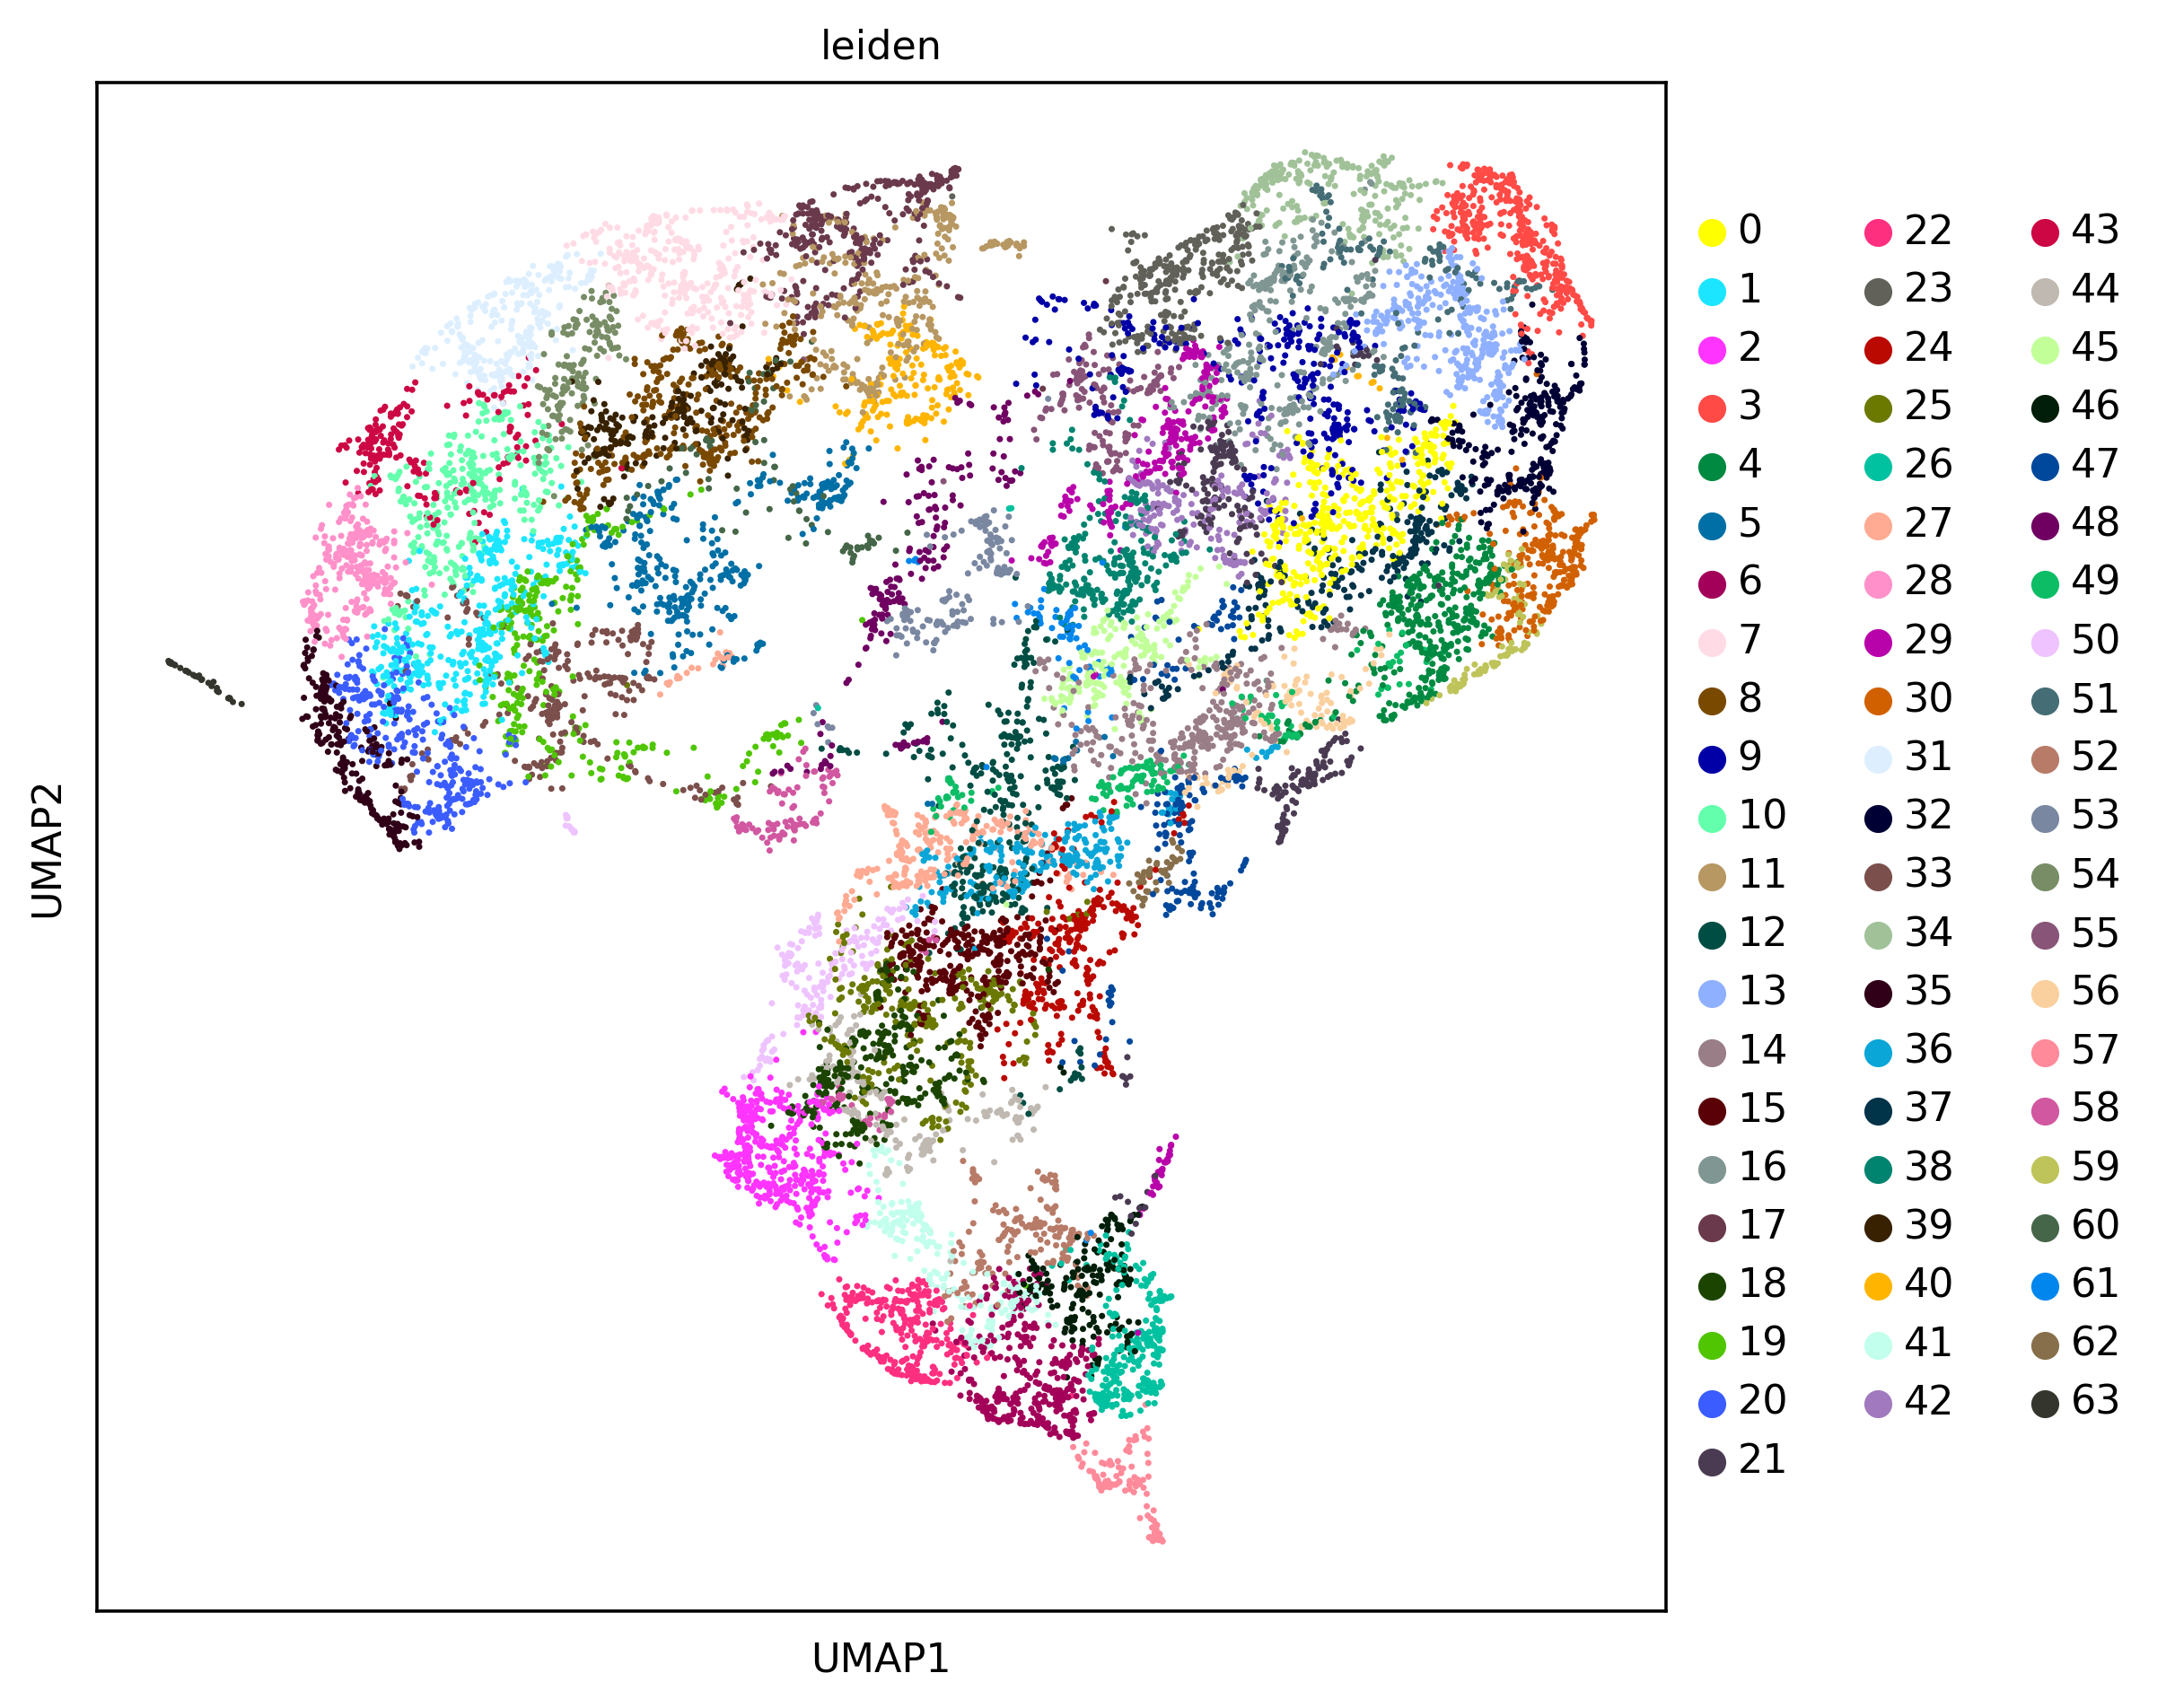

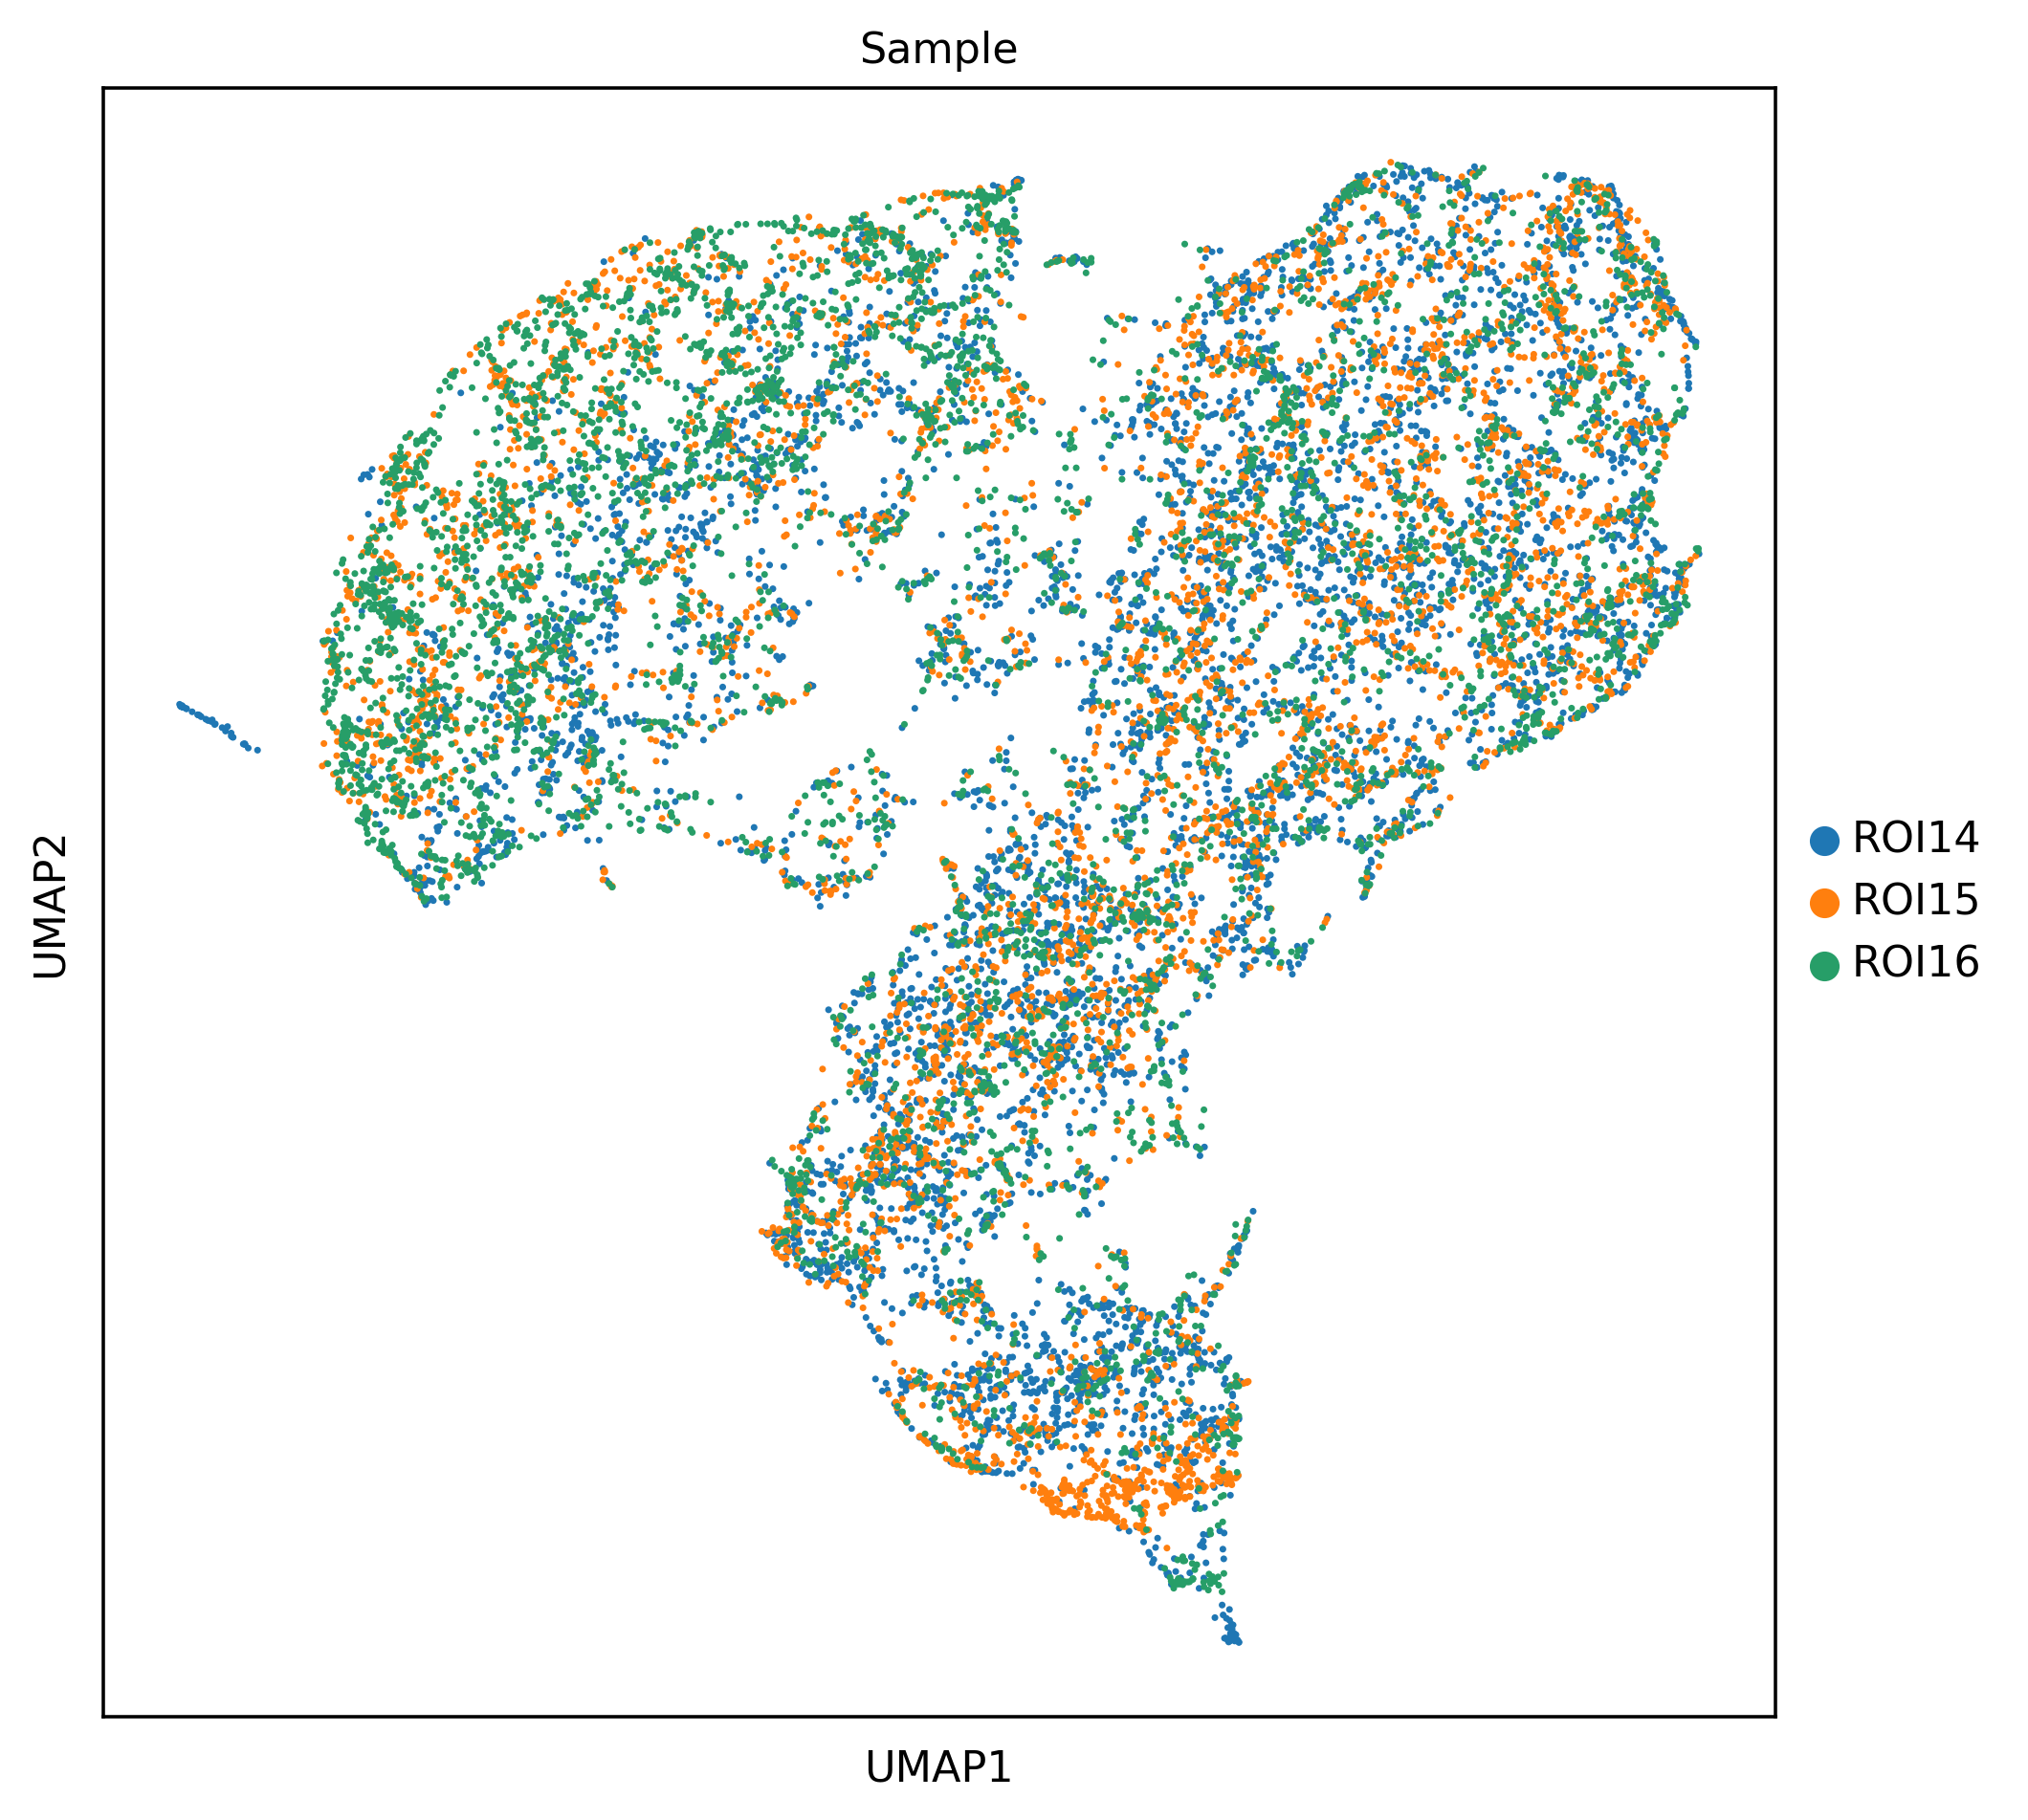

In [15]:
sc.settings.set_figure_params(dpi=160, fontsize=10, dpi_save=300, figsize=(7,7))
sc.pl.umap(adata_zscore, color ='leiden', s=10, use_raw=False, save='_leiden_legendOnDataCorr.pdf', legend_loc='on data',legend_fontsize=10)
sc.pl.umap(adata_zscore, color ='leiden', s=10, use_raw=False, save='_leidenCorr.pdf', legend_fontsize=10)
sc.pl.umap(adata_zscore, color ='Sample', s=10, save='_batchesCorr.pdf', legend_fontsize=10)

# Matrix plots

In [16]:
adata_zscore

AnnData object with n_obs × n_vars = 15604 × 38
    obs: 'Sample', 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Sample_colors'
    obsm: 'spatial', 'X_pca', 'X_umap', 'X_harmony'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [17]:
# median per cluster for heatmap
def median_cluster(data, numOfCluster, cluster):
    cluster_count = 0
    cluster_df = pd.DataFrame(columns=data.columns.to_list())

    while cluster_count < numOfCluster:
        id_of_cluster = [key for key, val in cluster.items() if val == str(cluster_count)] # get all IDs of one cluster
        df_of_cluster = data.loc[id_of_cluster] # generate a dataframe with only the IDs of one cluster 
        median_of_cluster = df_of_cluster.median().to_frame().T # compute the median per marker (column)
        cluster_df = pd.concat([cluster_df, median_of_cluster]) # merge the median results in a dataframe
        cluster_count += 1
    
    cluster_df = cluster_df.reset_index()
    cluster_df = cluster_df.drop('index', axis=1)

    return cluster_df

In [18]:
ROI = median_cluster( adata_zscore.to_df(), 64, adata_zscore.obs['leiden'])

In [19]:
sns.set(font_scale=0.8)
def plotHeatmap(data, name):
    plot= sns.clustermap(data.T,
                         standard_scale=1,  # Either 0 (rows) or 1 (columns).
                         cmap='Reds', 
                         yticklabels=True, xticklabels=True,
                         figsize=(10, 10),
                         row_cluster=False,
                         col_cluster=True)
    plot.fig.suptitle('Merge HCC', y=1, fontsize=12) 
    plot = plt.savefig('matrixplot' + name + '.pdf', dpi=250);

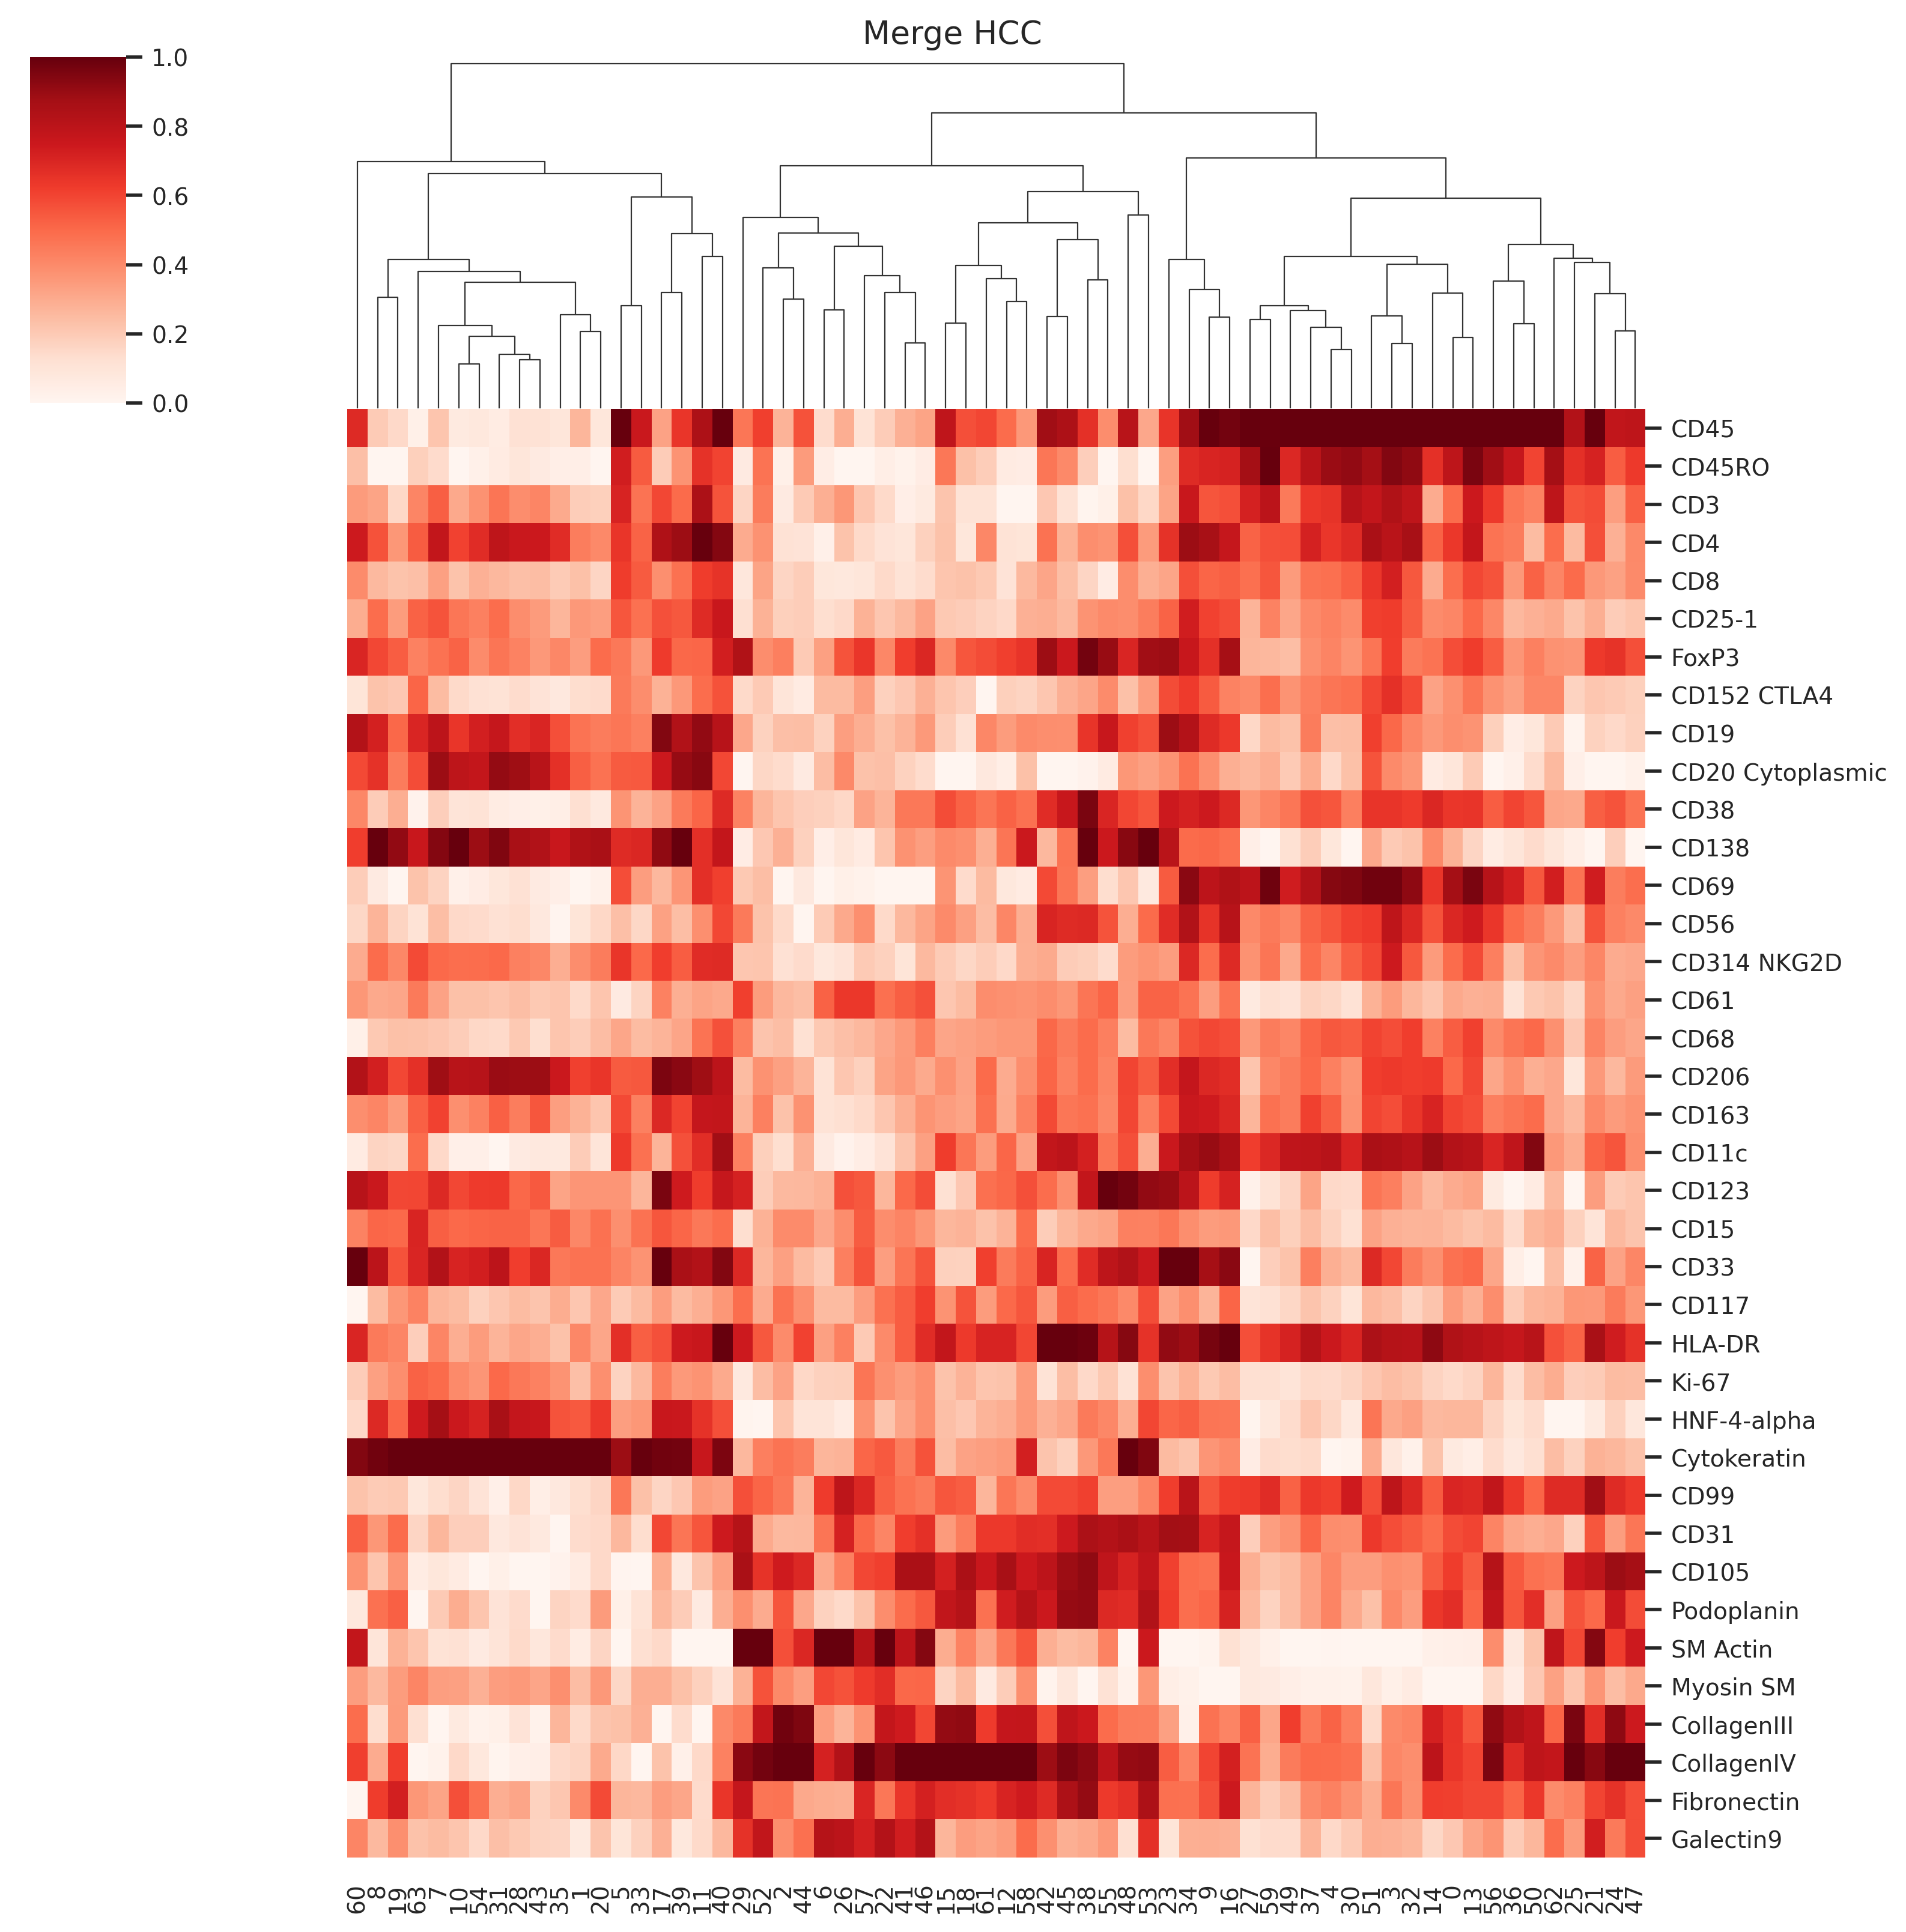

In [20]:
plotHeatmap(ROI, 'all HCC')

In [21]:
sns.set(font_scale=1)
def plotHeatmapAll(data, name):
    plot= sns.clustermap(data.T,
                         standard_scale=1,  # Either 0 (rows) or 1 (columns).
                         cmap='Reds', 
                         yticklabels=True, xticklabels=True,
                         figsize=(10, 10),
                         row_cluster=True,
                         col_cluster=True,
                         dendrogram_ratio=0.1)

    plt.setp(plot.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    plt.setp(plot.ax_heatmap.xaxis.get_majorticklabels(), rotation=35, ha='right', rotation_mode='anchor')
    plt.subplots_adjust(top=0.98) # space between title and plot
    plot.fig.suptitle('Cell Type Annotation ' + name,  y=1, fontsize=12) 
    plot.fig.subplots_adjust(right=0.7)
    plot.ax_cbar.set_position((0.89, .28, .015, .4))
    plot = plt.savefig('Newmatrixplot.pdf', dpi=250, bbox_inches='tight');

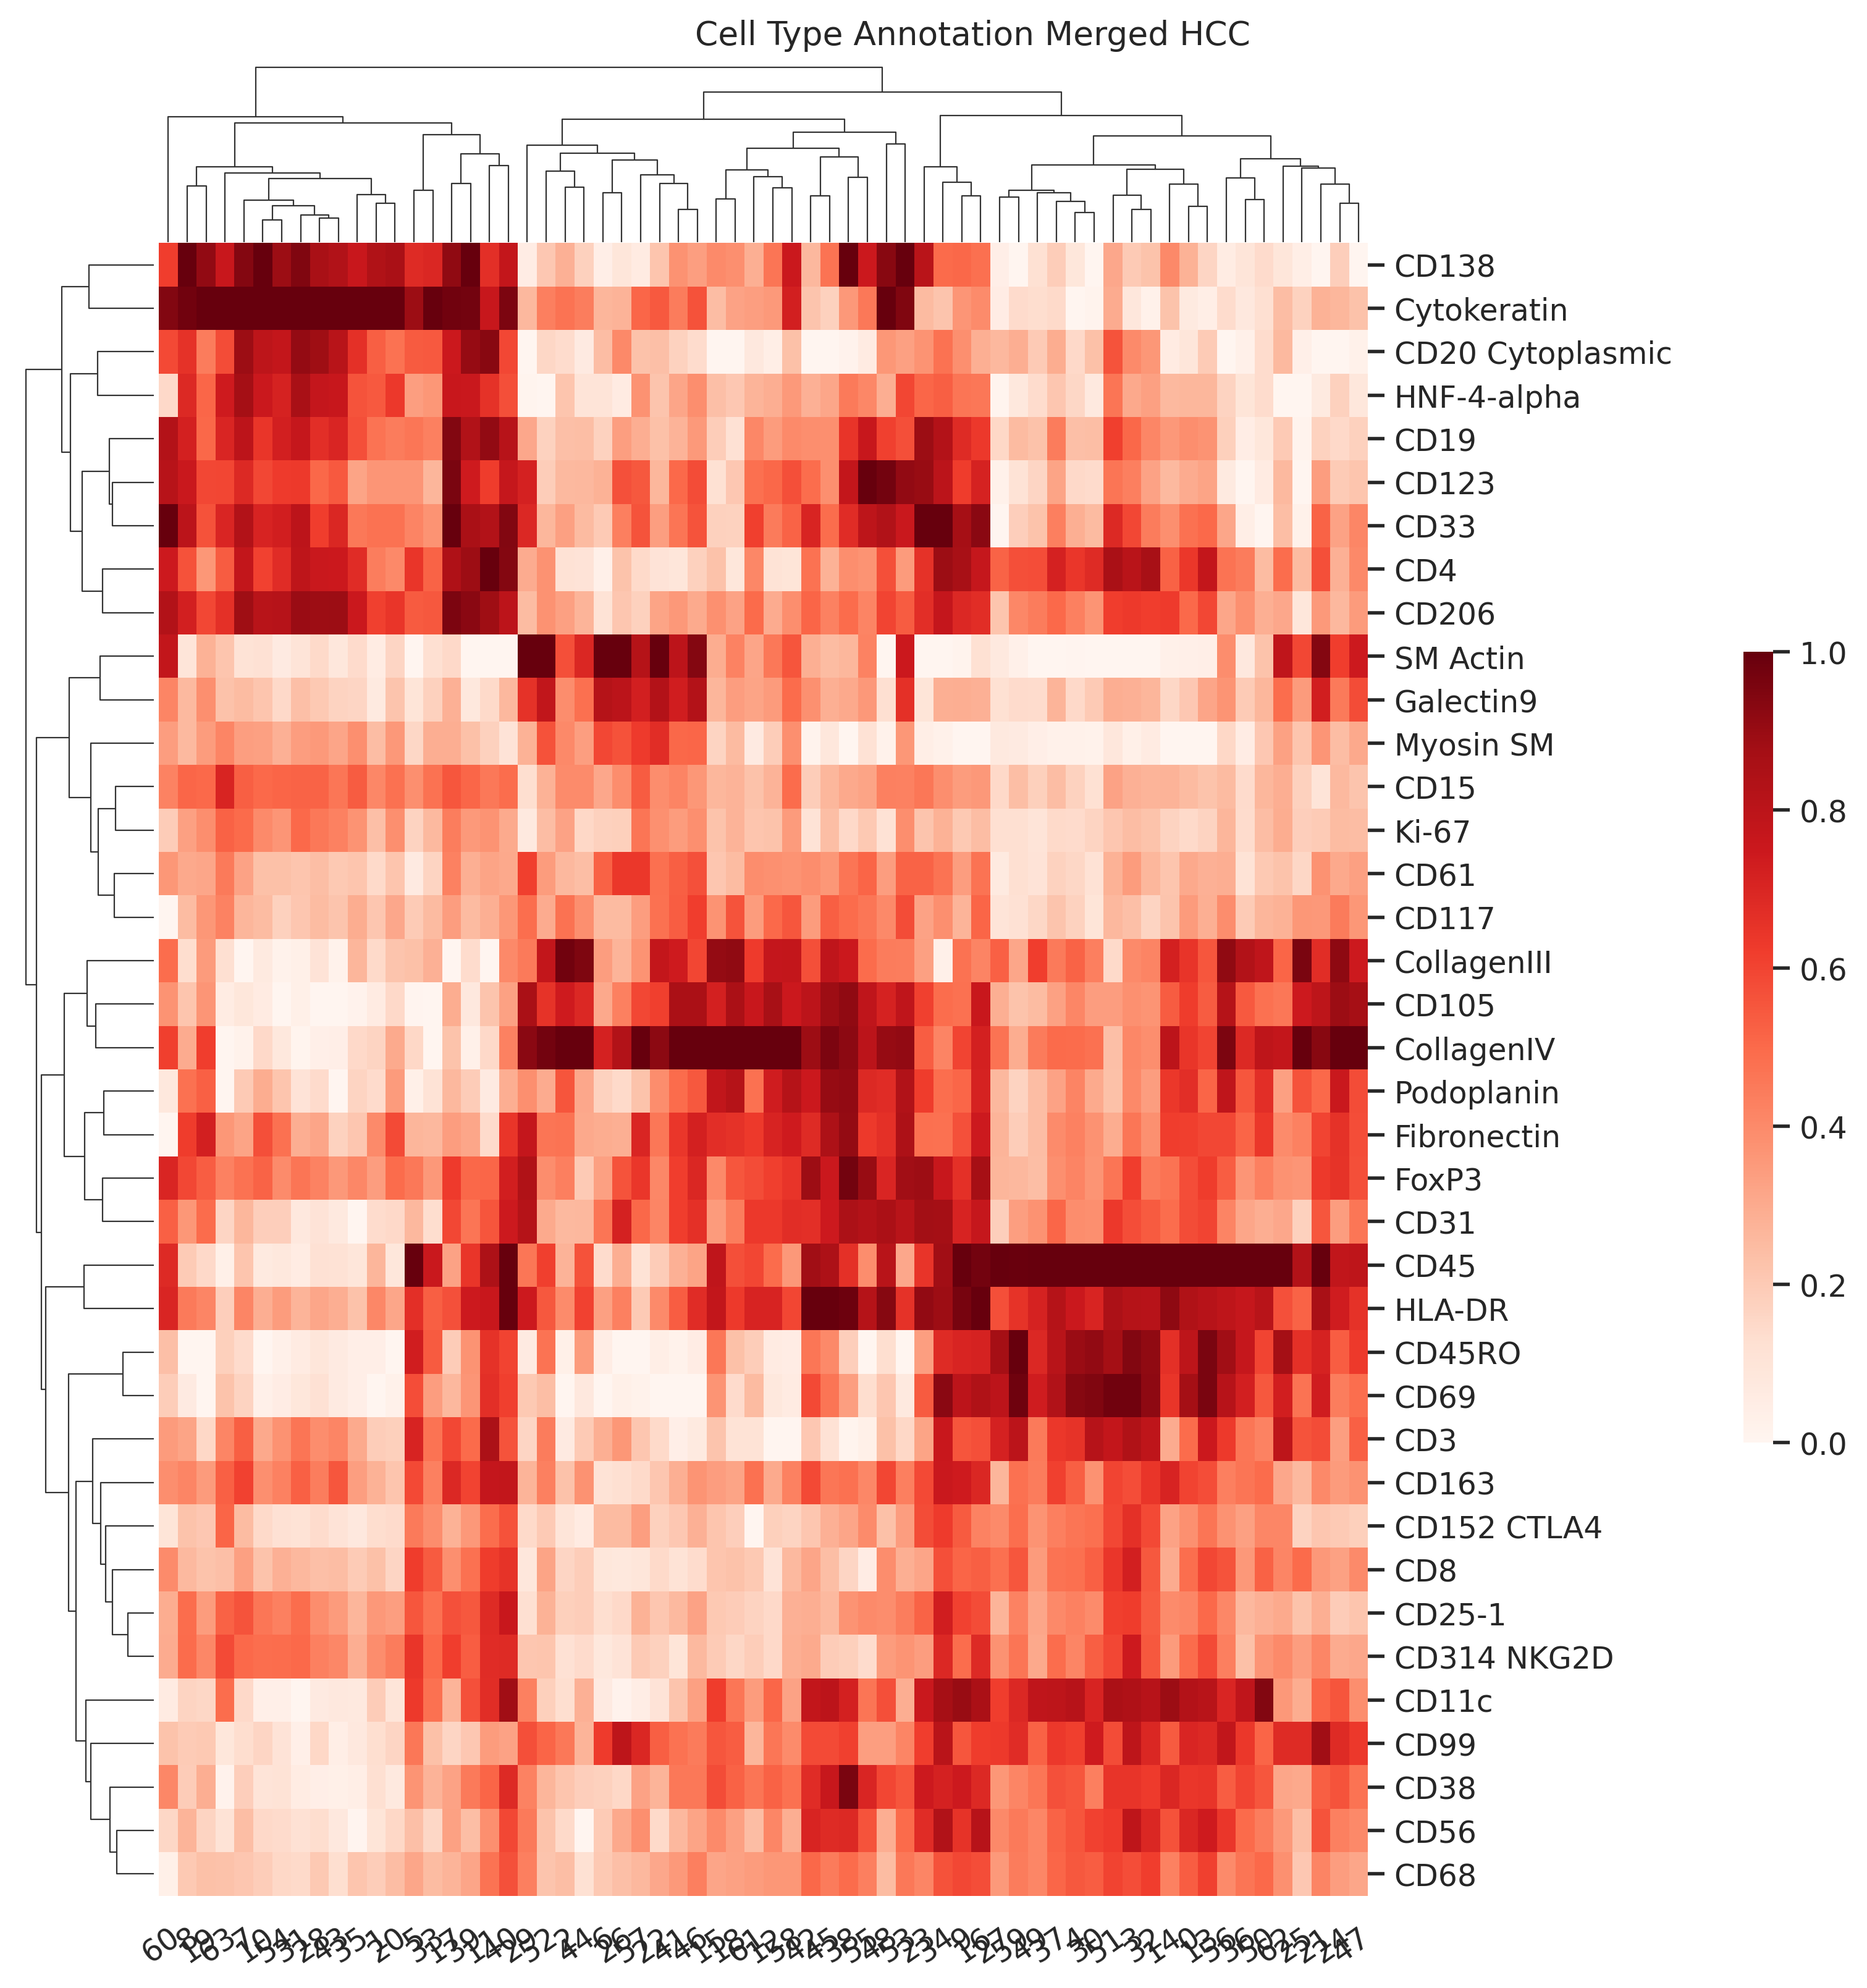

In [22]:
plotHeatmapAll(ROI, 'Merged HCC')

In [23]:
cellTypes=[
    'Activated T cells', #0
    'Fibroblasts', # 1
    'Tumour cells', # 2
    'Tumour cells', # 3
    'Activated T cells', # 4
    'Collagen',# 5
    'Collagen',# 6
    '7', # 7
    'Tumour cells', # 8
    'Activated T cells', # 9
    'Collagen',# 10
    'Activated T cells', # 11
    'Tumour cells', # 12
    'Collagen', # 13
    'Tumour cells?', # 14
    'Collagen', # 15
    'Tumour cells', # 16
    '17', # 17
    'Tumour cells', # 18
    'Activated T cells', # 19
    'Collagen', # 20
    'Collagen', # 21
    'Activated T cells', # 22
    'Collagen', # 23
    'Tumour cells', # 24

    
    
 
]

In [24]:
ROI.index = cellTypes

ValueError: Length mismatch: Expected axis has 64 elements, new values have 25 elements

In [ ]:
annotated_merged_data = ROI.groupby(level=0).mean()

In [ ]:
plotHeatmapAll(annotated_merged_data,  'Annotated')